# Libraries

In [402]:
options(warn=-1)
library(dplyr)
library(DataExplorer)
library(ggplot2)
library(tidyr)
library(patchwork)
library(cowplot)
library(scales)
library(tidyverse)
library(reshape2)
library(kableExtra)
library(vcd)
library(performanceEstimation)
library(class)
library(ipred)
library(caret)
library(mlbench)
library(ROCR)
library(pROC)
library(MASS)
library(countrycode)
library(randomForest);


Dołączanie pakietu: ‘MASS’


Następujący obiekt został zakryty z ‘package:patchwork’:

    area


Następujący obiekt został zakryty z ‘package:dplyr’:

    select




# Introduction

## Data description

In [2]:
path_data <- file.path("data", "adult.data")

In [5]:
adult_data <- read.csv(file=path_data, stringsAsFactors = TRUE, 
                       col.names=c("age", "workclass", "fnlwgt", "education", 
                                   "education.num","marital.status", "occupation", "relationship", "race","sex",
                                   "capital.gain", "capital.loss", "hours.per.week","native.country", "income"))

In [6]:
head(adult_data)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
,<int>,<fct>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K


In [7]:
nrow(adult_data)

[1] 32560

In [8]:
path_test <- file.path("data", "adult.test")

In [9]:
adult_test <- read.csv(file=path_test, stringsAsFactors = TRUE, 
                       col.names=c("age", "workclass", "fnlwgt", "education", 
                                   "education.num","marital.status", "occupation", "relationship", "race","sex",
                                   "capital.gain", "capital.loss", "hours.per.week","native.country", "income"))

In [10]:
head(adult_test)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
,<int>,<fct>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>
1,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
2,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
3,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
4,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
5,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.
6,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K.


In [11]:
nrow(adult_test)

[1] 16281

In [12]:
nrow(adult_data)+nrow(adult_test)

[1] 48841

## Data prepartion

In [13]:
adult_data <- subset(adult_data, select = -education.num)
adult_test <- subset(adult_test, select = -education.num)

In [14]:
trim_factor_columns <- function(x) {
  if (is.factor(x)) {
    x <- as.factor(trimws(as.character(x)))
  }
  return(x)
}

adult_data <- adult_data %>%
  mutate_if(is.factor, trim_factor_columns)
adult_test <- adult_test %>%
  mutate_if(is.factor, trim_factor_columns)

### Missing values

In [15]:
sum(complete.cases(adult_data))

[1] 32560

In [16]:
columns_names_with_question <- names(adult_data)[sapply(adult_data, function(col) any(col == "?"))]
columns_names_with_question

[1] "workclass"      "occupation"     "native.country"

In [17]:
names(adult_test)[sapply(adult_test, function(col) any(col == "?"))]

[1] "workclass"      "occupation"     "native.country"

In [18]:
for (col_name in columns_names_with_question) {
  adult_data[[col_name]][adult_data[[col_name]] == "?"] <- NA
}

In [19]:
columns_with_na <- colSums(is.na(adult_data)) > 0
columns_with_na

age      workclass         fnlwgt      education marital.status 
         FALSE           TRUE          FALSE          FALSE          FALSE 
    occupation   relationship           race            sex   capital.gain 
          TRUE          FALSE          FALSE          FALSE          FALSE 
  capital.loss hours.per.week native.country         income 
         FALSE          FALSE           TRUE          FALSE

In [20]:
sum(complete.cases(adult_data))

[1] 30161

In [21]:
sum(is.na(adult_data))
#some of them are for the same observation

[1] 4262

In [22]:
rows_with_na <- which(!complete.cases(adult_data))
head(adult_data[rows_with_na, c('workclass', 'occupation', 'native.country')], n=10)

,workclass,occupation,native.country
,<fct>,<fct>,<fct>
14,Private,Craft-repair,NA
27,NA,NA,South
38,Private,Sales,NA
51,Private,Other-service,NA
61,NA,NA,NA
69,NA,NA,United-States
77,NA,NA,United-States
93,Private,Sales,NA
106,NA,NA,United-States


In [23]:
sum(is.na(adult_data$workclass))
sum(is.na(adult_data$occupation))
sum(is.na(adult_data$native.country))

[1] 1836

[1] 1843

[1] 583

In [24]:
1836+1843+583

[1] 4262

In [25]:
missing_occupation <- round(sum(is.na(adult_data$occupation))/length(adult_data$occupation) * 100, 2)
missing_workclass <- round(sum(is.na(adult_data$workclass))/length(adult_data$workclass) * 100, 2)
missing_country <- round(sum(is.na(adult_data$native.country))/length(adult_data$native.country) * 100, 2)

occupation_data <- data.frame(Label = c("Missing", "Non-Missing"),
                           Value = c(missing_occupation, 100 - missing_occupation))
workclass_data <- data.frame(Label = c("Missing", "Non-Missing"),
                           Value = c(missing_workclass, 100 - missing_workclass)) 
country_data <- data.frame(Label = c("Missing", "Non-Missing"),
                           Value = c(missing_country, 100 - missing_country))

In [26]:
create_pie_chart <- function(df, title) {
    ggplot(df, aes(x="", y= Value, fill=Label)) +
    geom_bar(stat='identity') +
    coord_polar('y')+
    labs(title=title, fill="") +
    theme_void() +
    scale_fill_manual(values = c("Missing" = "salmon", "Non-Missing" = "skyblue")) +
    geom_text(aes(label = paste0(Value, "%")), position = position_stack(vjust = 0.5), size = 6) +
    theme(legend.position = c(0.15, 0.15),
          plot.title = element_text(hjust = 0.5, size=20),
          legend.text = element_text(size = 14))
}

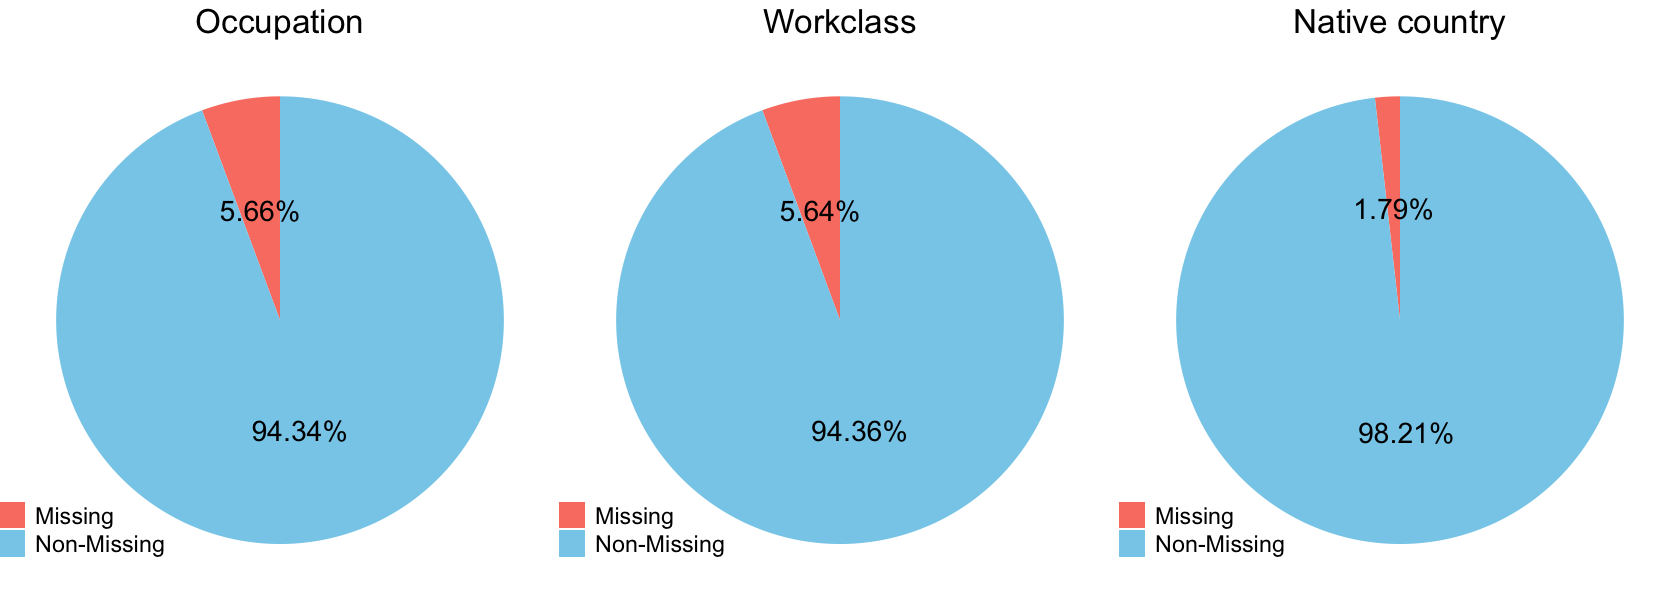

In [27]:
options(repr.plot.width=14, repr.plot.height=5)
nan_plot <- plot_grid(
  create_pie_chart(occupation_data, "Occupation"),
  create_pie_chart(workclass_data, "Workclass"),
  create_pie_chart(country_data, "Native country"),
  nrow = 1
)
nan_plot
ggsave("images/nan_pie_chart.jpg", nan_plot, width = 14, height = 5, units = "in", dpi = 300)

Let's get rid of rows with missing values and see what happens. 

In [28]:
clean_df <- na.omit(adult_data)
clean_df <- droplevels(clean_df)

In [29]:
nrow(clean_df)

[1] 30161

Check if some levels disaapeared or if sumarries of numerical columns significantly different. Check in percentages how many observations in each level went off. 

In [30]:
calculate_percentage_changes <- function(column_name) {
  summary_original <- table(adult_data[[column_name]])
  
  summary_clean <- table(clean_df[[column_name]])
  
  all_levels <- unique(c(names(summary_original), names(summary_clean)))
  
  df_original <- data.frame(level = names(summary_original), 
                            original_freq = as.numeric(summary_original) / sum(summary_original) * 100)
  df_clean <- data.frame(level = names(summary_clean), 
                         clean_freq = as.numeric(summary_clean) / sum(summary_clean) * 100)
  
  merged_df <- merge(df_original, df_clean, by = "level", all = TRUE)
  summary_original <- summary_original[all_levels]
  summary_clean <- summary_clean[all_levels]
  decrease <- summary_original - summary_clean
  percentage_decrease <- (decrease / summary_original) * 100  
  merged_df$percentage_decrease <- with(merged_df, percentage_decrease)
  
  return(merged_df)
}

In [31]:
summary(adult_data$age)
summary(clean_df$age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  17.00   28.00   37.00   38.58   48.00   90.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  17.00   28.00   37.00   38.44   47.00   90.00 

In [32]:
summary(adult_data$workclass)
summary(clean_df$workclass)
as.data.frame(calculate_percentage_changes("workclass"))

?      Federal-gov        Local-gov     Never-worked 
               0              960             2093                7 
         Private     Self-emp-inc Self-emp-not-inc        State-gov 
           22696             1116             2541             1297 
     Without-pay             NA's 
              14             1836

Federal-gov        Local-gov          Private     Self-emp-inc 
             943             2067            22286             1074 
Self-emp-not-inc        State-gov      Without-pay 
            2499             1278               14

level,original_freq,clean_freq,percentage_decrease
<chr>,<dbl>,<dbl>,<table[1d]>
?,0.00000000,NA,NA
Federal-gov,3.12459315,3.12655416,1.770833
Local-gov,6.81226403,6.85322105,1.242236
Never-worked,0.02278349,NA,NA
Private,73.87058977,73.89012301,1.806486
Self-emp-inc,3.63233954,3.56088989,3.763441
Self-emp-not-inc,8.27040750,8.28553430,1.652893
State-gov,4.22145554,4.23726004,1.464919
Without-pay,0.04556698,0.04641756,0.000000


In [33]:
filter(adult_data, workclass == "Never-worked")

age,workclass,fnlwgt,education,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>
18,Never-worked,206359,10th,Never-married,NA,Own-child,White,Male,0,0,40,United-States,<=50K
23,Never-worked,188535,7th-8th,Divorced,NA,Not-in-family,White,Male,0,0,35,United-States,<=50K
17,Never-worked,237272,10th,Never-married,NA,Own-child,White,Male,0,0,30,United-States,<=50K
18,Never-worked,157131,11th,Never-married,NA,Own-child,White,Female,0,0,10,United-States,<=50K
20,Never-worked,462294,Some-college,Never-married,NA,Own-child,Black,Male,0,0,40,United-States,<=50K
30,Never-worked,176673,HS-grad,Married-civ-spouse,NA,Wife,Black,Female,0,0,40,United-States,<=50K
18,Never-worked,153663,Some-college,Never-married,NA,Own-child,White,Male,0,0,4,United-States,<=50K


In [34]:
adult_data[(is.na(adult_data$workclass) | is.na(adult_data$occupation)) & !(is.na(adult_data$workclass) & is.na(adult_data$occupation)), ]

,age,workclass,fnlwgt,education,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>
5361,18,Never-worked,206359,10th,Never-married,NA,Own-child,White,Male,0,0,40,United-States,<=50K
10845,23,Never-worked,188535,7th-8th,Divorced,NA,Not-in-family,White,Male,0,0,35,United-States,<=50K
14772,17,Never-worked,237272,10th,Never-married,NA,Own-child,White,Male,0,0,30,United-States,<=50K
20337,18,Never-worked,157131,11th,Never-married,NA,Own-child,White,Female,0,0,10,United-States,<=50K
23232,20,Never-worked,462294,Some-college,Never-married,NA,Own-child,Black,Male,0,0,40,United-States,<=50K
32304,30,Never-worked,176673,HS-grad,Married-civ-spouse,NA,Wife,Black,Female,0,0,40,United-States,<=50K
32314,18,Never-worked,153663,Some-college,Never-married,NA,Own-child,White,Male,0,0,4,United-States,<=50K


In [35]:
filter(adult_data, is.na(occupation))

age,workclass,fnlwgt,education,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>
54,NA,180211,Some-college,Married-civ-spouse,NA,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
32,NA,293936,7th-8th,Married-spouse-absent,NA,Not-in-family,White,Male,0,0,40,NA,<=50K
25,NA,200681,Some-college,Never-married,NA,Own-child,White,Male,0,0,40,United-States,<=50K
67,NA,212759,10th,Married-civ-spouse,NA,Husband,White,Male,0,0,2,United-States,<=50K
17,NA,304873,10th,Never-married,NA,Own-child,White,Female,34095,0,32,United-States,<=50K
35,NA,129305,HS-grad,Married-civ-spouse,NA,Husband,White,Male,0,0,40,United-States,<=50K
43,NA,174662,Some-college,Divorced,NA,Not-in-family,White,Female,0,0,40,United-States,<=50K
52,NA,252903,HS-grad,Divorced,NA,Not-in-family,White,Male,0,0,45,United-States,>50K
68,NA,38317,1st-4th,Divorced,NA,Not-in-family,White,Female,0,0,20,United-States,<=50K


In [36]:
filter(adult_data, is.na(native.country))

age,workclass,fnlwgt,education,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>
40,Private,121772,Assoc-voc,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,NA,>50K
31,Private,84154,Some-college,Married-civ-spouse,Sales,Husband,White,Male,0,0,38,NA,>50K
18,Private,226956,HS-grad,Never-married,Other-service,Own-child,White,Female,0,0,30,NA,<=50K
32,NA,293936,7th-8th,Married-spouse-absent,NA,Not-in-family,White,Male,0,0,40,NA,<=50K
30,Private,117747,HS-grad,Married-civ-spouse,Sales,Wife,Asian-Pac-Islander,Female,0,1573,35,NA,<=50K
56,Private,203580,HS-grad,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,35,NA,<=50K
45,Private,153141,HS-grad,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,NA,<=50K
39,NA,157443,Masters,Married-civ-spouse,NA,Wife,Asian-Pac-Islander,Female,3464,0,40,NA,<=50K
34,State-gov,98101,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,7688,0,45,NA,>50K


In [37]:
filter(adult_data, is.na(workclass))

age,workclass,fnlwgt,education,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>
54,NA,180211,Some-college,Married-civ-spouse,NA,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
32,NA,293936,7th-8th,Married-spouse-absent,NA,Not-in-family,White,Male,0,0,40,NA,<=50K
25,NA,200681,Some-college,Never-married,NA,Own-child,White,Male,0,0,40,United-States,<=50K
67,NA,212759,10th,Married-civ-spouse,NA,Husband,White,Male,0,0,2,United-States,<=50K
17,NA,304873,10th,Never-married,NA,Own-child,White,Female,34095,0,32,United-States,<=50K
35,NA,129305,HS-grad,Married-civ-spouse,NA,Husband,White,Male,0,0,40,United-States,<=50K
43,NA,174662,Some-college,Divorced,NA,Not-in-family,White,Female,0,0,40,United-States,<=50K
52,NA,252903,HS-grad,Divorced,NA,Not-in-family,White,Male,0,0,45,United-States,>50K
68,NA,38317,1st-4th,Divorced,NA,Not-in-family,White,Female,0,0,20,United-States,<=50K


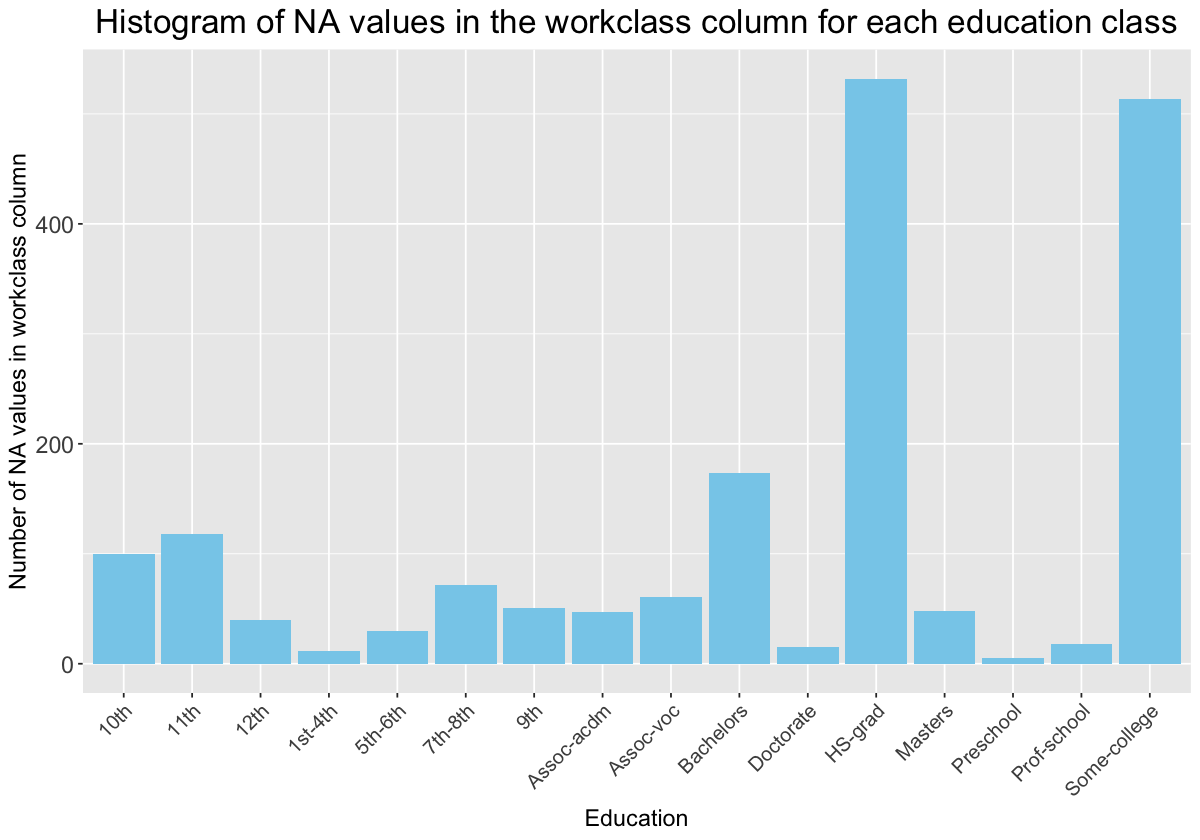

In [38]:
na_count <- adult_data %>%
  group_by(education, workclass) %>%
  summarise(na_count = sum(is.na(workclass)), .groups = "drop")

options(repr.plot.width=10, repr.plot.height=7)

workclass_na_hist <- ggplot(na_count, aes(x = education, y = na_count, fill = workclass)) +
  geom_bar(stat = "identity", position = "dodge", fill = 'skyblue') +
  labs(title = "Histogram of NA values in the workclass column for each education class",
       x = "Education",
       y = "Number of NA values in workclass column") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size=12),
          axis.text.y = element_text(size=14),
          axis.title = element_text(size=14),
          plot.title = element_text(hjust = 0.5, size=20)) +
  guides(fill = FALSE)

workclass_na_hist

ggsave("images/workclass_na_hist.jpg", workclass_na_hist, width = 10, height = 7, units = "in", dpi = 300)

In [39]:
summary(adult_data$fnlwgt)
summary(clean_df$fnlwgt)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  12285  117832  178363  189782  237054 1484705 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  13769  117628  178429  189798  237630 1484705 

In [40]:
summary(adult_data$education)
summary(clean_df$education)
as.data.frame(calculate_percentage_changes("education"))

10th         11th         12th      1st-4th      5th-6th      7th-8th 
         933         1175          433          168          333          646 
         9th   Assoc-acdm    Assoc-voc    Bachelors    Doctorate      HS-grad 
         514         1067         1382         5354          413        10501 
     Masters    Preschool  Prof-school Some-college 
        1723           51          576         7291

10th         11th         12th      1st-4th      5th-6th      7th-8th 
         820         1048          377          151          288          557 
         9th   Assoc-acdm    Assoc-voc    Bachelors    Doctorate      HS-grad 
         455         1008         1307         5043          375         9840 
     Masters    Preschool  Prof-school Some-college 
        1627           45          542         6678

level,original_freq,clean_freq,percentage_decrease
<chr>,<dbl>,<dbl>,<table[1d]>
10th,2.8654791,2.7187427,12.111468
11th,3.6087224,3.4746859,10.808511
12th,1.3298526,1.2499586,12.933025
1st-4th,0.5159705,0.5006465,10.119048
5th-6th,1.0227273,0.9548755,13.513514
7th-8th,1.9840295,1.8467557,13.777090
9th,1.5786241,1.5085707,11.478599
Assoc-acdm,3.2770270,3.3420643,5.529522
Assoc-voc,4.2444717,4.3334107,5.426918


In [41]:
summary(adult_data$marital.status)
summary(clean_df$marital.status)
as.data.frame(calculate_percentage_changes("marital.status"))

Divorced     Married-AF-spouse    Married-civ-spouse 
                 4443                    23                 14976 
Married-spouse-absent         Never-married             Separated 
                  418                 10682                  1025 
              Widowed 
                  993

Divorced     Married-AF-spouse    Married-civ-spouse 
                 4214                    21                 14065 
Married-spouse-absent         Never-married             Separated 
                  370                  9725                   939 
              Widowed 
                  827

level,original_freq,clean_freq,percentage_decrease
<chr>,<dbl>,<dbl>,<table[1d]>
Divorced,13.64557740,13.97168529,5.154175
Married-AF-spouse,0.07063882,0.06962634,8.695652
Married-civ-spouse,45.99508600,46.63306920,6.083066
Married-spouse-absent,1.28378378,1.22674978,11.483254
Never-married,32.80712531,32.24362587,8.958996
Separated,3.14803440,3.11329200,8.390244
Widowed,3.04975430,2.74195153,16.717019


In [42]:
summary(adult_data$occupation)
summary(clean_df$occupation)
as.data.frame(calculate_percentage_changes("occupation"))

?      Adm-clerical      Armed-Forces      Craft-repair 
                0              3769                 9              4099 
  Exec-managerial   Farming-fishing Handlers-cleaners Machine-op-inspct 
             4066               994              1370              2002 
    Other-service   Priv-house-serv    Prof-specialty   Protective-serv 
             3295               149              4140               649 
            Sales      Tech-support  Transport-moving              NA's 
             3650               928              1597              1843

Adm-clerical      Armed-Forces      Craft-repair   Exec-managerial 
             3720                 9              4030              3992 
  Farming-fishing Handlers-cleaners Machine-op-inspct     Other-service 
              989              1350              1966              3212 
  Priv-house-serv    Prof-specialty   Protective-serv             Sales 
              143              4038               644              3584 
     Tech-support  Transport-moving 
              912              1572

level,original_freq,clean_freq,percentage_decrease
<chr>,<dbl>,<dbl>,<table[1d]>
?,0.00000000,NA,NA
Adm-clerical,12.27007846,12.33380856,1.3000796
Armed-Forces,0.02929974,0.02983986,0.0000000
Craft-repair,13.34440212,13.36162594,1.6833374
Exec-managerial,13.23696976,13.23563542,1.8199705
Farming-fishing,3.23599310,3.27906900,0.5030181
Handlers-cleaners,4.46007097,4.47597891,1.4598540
Machine-op-inspct,6.51756356,6.51835151,1.7982018
Other-service,10.72695901,10.64951427,2.5189681


In [43]:
summary(adult_data$relationship)
summary(clean_df$relationship)
as.data.frame(calculate_percentage_changes("relationship"))

Husband  Not-in-family Other-relative      Own-child      Unmarried 
         13193           8304            981           5068           3446 
          Wife 
          1568

Husband  Not-in-family Other-relative      Own-child      Unmarried 
         12463           7725            889           4466           3212 
          Wife 
          1406

level,original_freq,clean_freq,percentage_decrease
<chr>,<dbl>,<dbl>,<table[1d]>
Husband,40.519042,41.321574,5.533237
Not-in-family,25.503686,25.612546,6.972543
Other-relative,3.012899,2.947515,9.378186
Own-child,15.565111,14.807201,11.878453
Unmarried,10.583538,10.649514,6.790482
Wife,4.815725,4.661649,10.331633


In [44]:
summary(adult_data$race)
summary(clean_df$race)
as.data.frame(calculate_percentage_changes("race"))

Amer-Indian-Eskimo Asian-Pac-Islander              Black              Other 
               311               1039               3124                271 
             White 
             27815

Amer-Indian-Eskimo Asian-Pac-Islander              Black              Other 
               286                895               2817                231 
             White 
             25932

level,original_freq,clean_freq,percentage_decrease
<chr>,<dbl>,<dbl>,<table[1d]>
Amer-Indian-Eskimo,0.9551597,0.9482444,8.038585
Asian-Pac-Islander,3.1910319,2.9674082,13.859480
Black,9.5945946,9.3398760,9.827145
Other,0.8323096,0.7658897,14.760148
White,85.4269042,85.9785816,6.769729


In [45]:
summary(adult_data$sex)
summary(clean_df$sex)
as.data.frame(calculate_percentage_changes("sex"))

Female   Male 
 10771  21789

Female   Male 
  9782  20379

level,original_freq,clean_freq,percentage_decrease
<chr>,<dbl>,<dbl>,<table[1d]>
Female,33.08047,32.43261,9.182063
Male,66.91953,67.56739,6.471155


In [46]:
summary(adult_data$capital.gain)
summary(clean_df$capital.gain)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0    1078       0   99999 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0    1092       0   99999 

In [47]:
summary(adult_data$capital.loss)
summary(clean_df$capital.loss)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00   87.31    0.00 4356.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00   88.38    0.00 4356.00 

In [48]:
summary(adult_data$hours.per.week)
summary(clean_df$hours.per.week)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   40.00   40.00   40.44   45.00   99.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   40.00   40.00   40.93   45.00   99.00 

In [49]:
unique(adult_data$hours.per.week)

[1] 13 40 16 45 50 80 30 35 60 20 52 44 15 25 38 43 55 48 58 32 70  2 22 56 41
[26] 28 36 24 46 42 12 65  1 10 34 75 98 33 54  8  6 64 19 18 72  5  9 47 37 21
[51] 26 14  4 59  7 99 53 39 62 57 78 90 66 11 49 84  3 17 68 27 85 31 51 77 63
[76] 23 87 88 73 89 97 94 29 96 67 82 86 91 81 76 92 61 74 95

In [50]:
summary(adult_data$native.country)
summary(clean_df$native.country)
as.data.frame(calculate_percentage_changes("native.country"))

?                   Cambodia 
                         0                         19 
                    Canada                      China 
                       121                         75 
                  Columbia                       Cuba 
                        59                         95 
        Dominican-Republic                    Ecuador 
                        70                         28 
               El-Salvador                    England 
                       106                         90 
                    France                    Germany 
                        29                        137 
                    Greece                  Guatemala 
                        29                         64 
                     Haiti         Holand-Netherlands 
                        44                          1 
                  Honduras                       Hong 
                        13                         20 
                   Hungary                      India 
                        13                        100 
                      Iran                    Ireland 
                        43                         24 
                     Italy                    Jamaica 
                        73                         81 
                     Japan                       Laos 
                        62                         18 
                    Mexico                  Nicaragua 
                       643                         34 
Outlying-US(Guam-USVI-etc)                       Peru 
                        14                         31 
               Philippines                     Poland 
                       198                         60 
                  Portugal                Puerto-Rico 
                        37                        114 
                  Scotland                      South 
                        12                         80 
                    Taiwan                   Thailand 
                        51                         18 
           Trinadad&Tobago              United-States 
                        19                      29169 
                   Vietnam                 Yugoslavia 
                        67                         16 
                      NA's 
                       583

Cambodia                     Canada 
                        18                        107 
                     China                   Columbia 
                        68                         56 
                      Cuba         Dominican-Republic 
                        92                         67 
                   Ecuador                El-Salvador 
                        27                        100 
                   England                     France 
                        86                         27 
                   Germany                     Greece 
                       128                         29 
                 Guatemala                      Haiti 
                        63                         42 
        Holand-Netherlands                   Honduras 
                         1                         12 
                      Hong                    Hungary 
                        19                         13 
                     India                       Iran 
                       100                         42 
                   Ireland                      Italy 
                        24                         68 
                   Jamaica                      Japan 
                        80                         59 
                      Laos                     Mexico 
                        17                        610 
                 Nicaragua Outlying-US(Guam-USVI-etc) 
                        33                         14 
                      Peru                Philippines 
                        30                        188 
                    Poland                   Portugal 
                        56                         34 
               Puerto-Rico                   Scotland 
                       109                         11 
                     South                     Taiwan 
                        71                         42 
                  Thailand            Trinadad&Tobago 
                        17                         18 
             United-States                    Vietnam 
                     27503                         64 
                Yugoslavia 
                        16

level,original_freq,clean_freq,percentage_decrease
<chr>,<dbl>,<dbl>,<table[1d]>
?,0.000000000,NA,NA
Cambodia,0.059417706,0.05967972,5.263158
Canada,0.378396973,0.35476277,11.570248
China,0.234543578,0.22545672,9.333333
Columbia,0.184507615,0.18567024,5.084746
Cuba,0.297088532,0.30502967,3.157895
Dominican-Republic,0.218907340,0.22214118,4.285714
Ecuador,0.087562936,0.08951958,3.571429
El-Salvador,0.331488257,0.33155399,5.660377


In [51]:
summary(adult_data$income)
summary(clean_df$income)
as.data.frame(calculate_percentage_changes("income"))

<=50K  >50K 
24719  7841

<=50K  >50K 
22653  7508

level,original_freq,clean_freq,percentage_decrease
<chr>,<dbl>,<dbl>,<table[1d]>
<=50K,75.9183,75.10693,8.357943
>50K,24.0817,24.89307,4.246907


And now check the contigency tables before and after cleaning.

In [52]:
cont_table <- function(df, column) {
  result <- df %>%
    group_by({{column}}, income, .drop = FALSE) %>%
    summarise(count = n(), .groups = "drop_last") %>%
    ungroup() %>%
    pivot_wider(names_from = {{column}}, values_from = count, values_fill = 0)
  return(result)
}

In [53]:
cont_table(adult_data, workclass)
cont_table(clean_df, workclass)

income,?,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,NA
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,0,589,1476,7,17733,494,1817,944,14,1645
>50K,0,371,617,0,4963,622,724,353,0,191


income,Federal-gov,Local-gov,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,578,1458,17410,474,1785,934,14
>50K,365,609,4876,600,714,344,0


In [54]:
cont_table(adult_data, education)
cont_table(clean_df, education)

income,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,871,1115,400,162,317,606,487,802,1021,3133,107,8826,764,51,153,5904
>50K,62,60,33,6,16,40,27,265,361,2221,306,1675,959,0,423,1387


income,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,761,989,348,145,276,522,430,752,963,2917,95,8223,709,45,136,5342
>50K,59,59,29,6,12,35,25,256,344,2126,280,1617,918,0,406,1336


In [55]:
cont_table(adult_data, marital.status)
cont_table(clean_df, marital.status)

income,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,3980,13,8284,384,10191,959,908
>50K,463,10,6692,34,491,66,85


income,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,3762,11,7666,339,9255,873,747
>50K,452,10,6399,31,470,66,80


In [56]:
cont_table(adult_data, occupation)
cont_table(clean_df, occupation)

income,?,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving,NA
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,0,3262,8,3170,2098,879,1284,1752,3158,148,2281,438,2667,645,1277,1652
>50K,0,507,1,929,1968,115,86,250,137,1,1859,211,983,283,320,191


income,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,3222,8,3122,2055,874,1267,1721,3080,142,2227,434,2614,634,1253
>50K,498,1,908,1937,115,83,245,132,1,1811,210,970,278,319


In [57]:
cont_table(adult_data, relationship)
cont_table(clean_df, relationship)

income,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
<fct>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,7275,7448,944,5001,3228,823
>50K,5918,856,37,67,218,745


income,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
<fct>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,6784,6902,854,4402,2999,712
>50K,5679,823,35,64,213,694


In [58]:
cont_table(adult_data, race)
cont_table(clean_df, race)

income,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
<fct>,<int>,<int>,<int>,<int>,<int>
<=50K,275,763,2737,246,20698
>50K,36,276,387,25,7117


income,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
<fct>,<int>,<int>,<int>,<int>,<int>
<=50K,252,647,2451,210,19093
>50K,34,248,366,21,6839


In [59]:
cont_table(adult_data,sex)
cont_table(clean_df, sex)

income,Female,Male
<fct>,<int>,<int>
<=50K,9592,15127
>50K,1179,6662


income,Female,Male
<fct>,<int>,<int>
<=50K,8670,13983
>50K,1112,6396


In [60]:
cont_table(adult_data, native.country)
cont_table(clean_df,  native.country)

income,?,Cambodia,Canada,China,Columbia,Cuba,Dominican-Republic,Ecuador,El-Salvador,⋯,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia,NA
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,0,12,82,55,57,70,68,24,97,⋯,102,9,64,31,15,17,21998,62,10,437
>50K,0,7,39,20,2,25,2,4,9,⋯,12,3,16,20,3,2,7171,5,6,146


income,Cambodia,Canada,China,Columbia,Cuba,Dominican-Republic,Ecuador,El-Salvador,England,⋯,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,11,71,48,54,67,65,23,91,56,⋯,30,97,9,57,23,14,16,20508,59,10
>50K,7,36,20,2,25,2,4,9,30,⋯,4,12,2,14,19,3,2,6995,5,6


In [61]:
#we can remove rows with missing values
write.csv(clean_df, file = "data/clean_data.csv", row.names = FALSE)

# Descriptive analysis and data visualisation

## Basic characteristics

In [26]:
clean_data <- read.csv('data/clean_data.csv', stringsAsFactors = TRUE)

In [27]:
nrow(clean_data)

[1] 30161

In [28]:
str(clean_data)

'data.frame':	30161 obs. of  14 variables:
 $ age           : int  50 38 53 28 37 49 52 31 42 37 ...
 $ workclass     : Factor w/ 7 levels "Federal-gov",..: 5 3 3 3 3 3 5 3 3 3 ...
 $ fnlwgt        : int  83311 215646 234721 338409 284582 160187 209642 45781 159449 280464 ...
 $ education     : Factor w/ 16 levels "10th","11th",..: 10 12 2 10 13 7 12 13 10 16 ...
 $ marital.status: Factor w/ 7 levels "Divorced","Married-AF-spouse",..: 3 1 3 3 3 4 3 5 3 3 ...
 $ occupation    : Factor w/ 14 levels "Adm-clerical",..: 4 6 6 10 4 8 4 10 4 4 ...
 $ relationship  : Factor w/ 6 levels "Husband","Not-in-family",..: 1 2 1 6 6 2 1 2 1 1 ...
 $ race          : Factor w/ 5 levels "Amer-Indian-Eskimo",..: 5 5 3 3 5 3 5 5 5 3 ...
 $ sex           : Factor w/ 2 levels "Female","Male": 2 2 2 1 1 1 2 1 2 2 ...
 $ capital.gain  : int  0 0 0 0 0 0 0 14084 5178 0 ...
 $ capital.loss  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ hours.per.week: int  13 40 40 40 40 16 45 50 40 80 ...
 $ native.country: Factor w/ 41 le

In [29]:
num_unique_values <- sapply(clean_data, function(x) length(unique(x)))

for (i in 1:length(num_unique_values)) {
  print(paste0(names(num_unique_values)[i], ": ", num_unique_values[i]))
}

[1] "age: 72"
[1] "workclass: 7"
[1] "fnlwgt: 20262"
[1] "education: 16"
[1] "marital.status: 7"
[1] "occupation: 14"
[1] "relationship: 6"
[1] "race: 5"
[1] "sex: 2"
[1] "capital.gain: 118"
[1] "capital.loss: 90"
[1] "hours.per.week: 94"
[1] "native.country: 41"
[1] "income: 2"


In [30]:
numerical_columns <- names(clean_data[sapply(clean_data, is.numeric)])
factor_columns <- names(clean_data[sapply(clean_data, is.factor)])

## Exploratory data analysis

#### Bar plots

In [31]:
bar_plots <- lapply(factor_columns, function(column) {
    ggplot(clean_data, aes_string(x = column)) +
    geom_bar(fill='skyblue') +
    labs(title = column) +
    scale_y_continuous(breaks = pretty_breaks(n = 6)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, size=14),
          axis.text.y = element_text(size=14),
          axis.title.x = element_blank(),
          plot.title = element_text(hjust = 0.5, size=20))
})

In [32]:
options(repr.plot.width=18, repr.plot.height=20)
plot_grid1 <- plot_grid(plotlist = bar_plots, ncol = 3, align = "h")
ggsave("images/barplots1.jpg", plot_grid1, width = 18, height = 20, units = "in", dpi = 300)

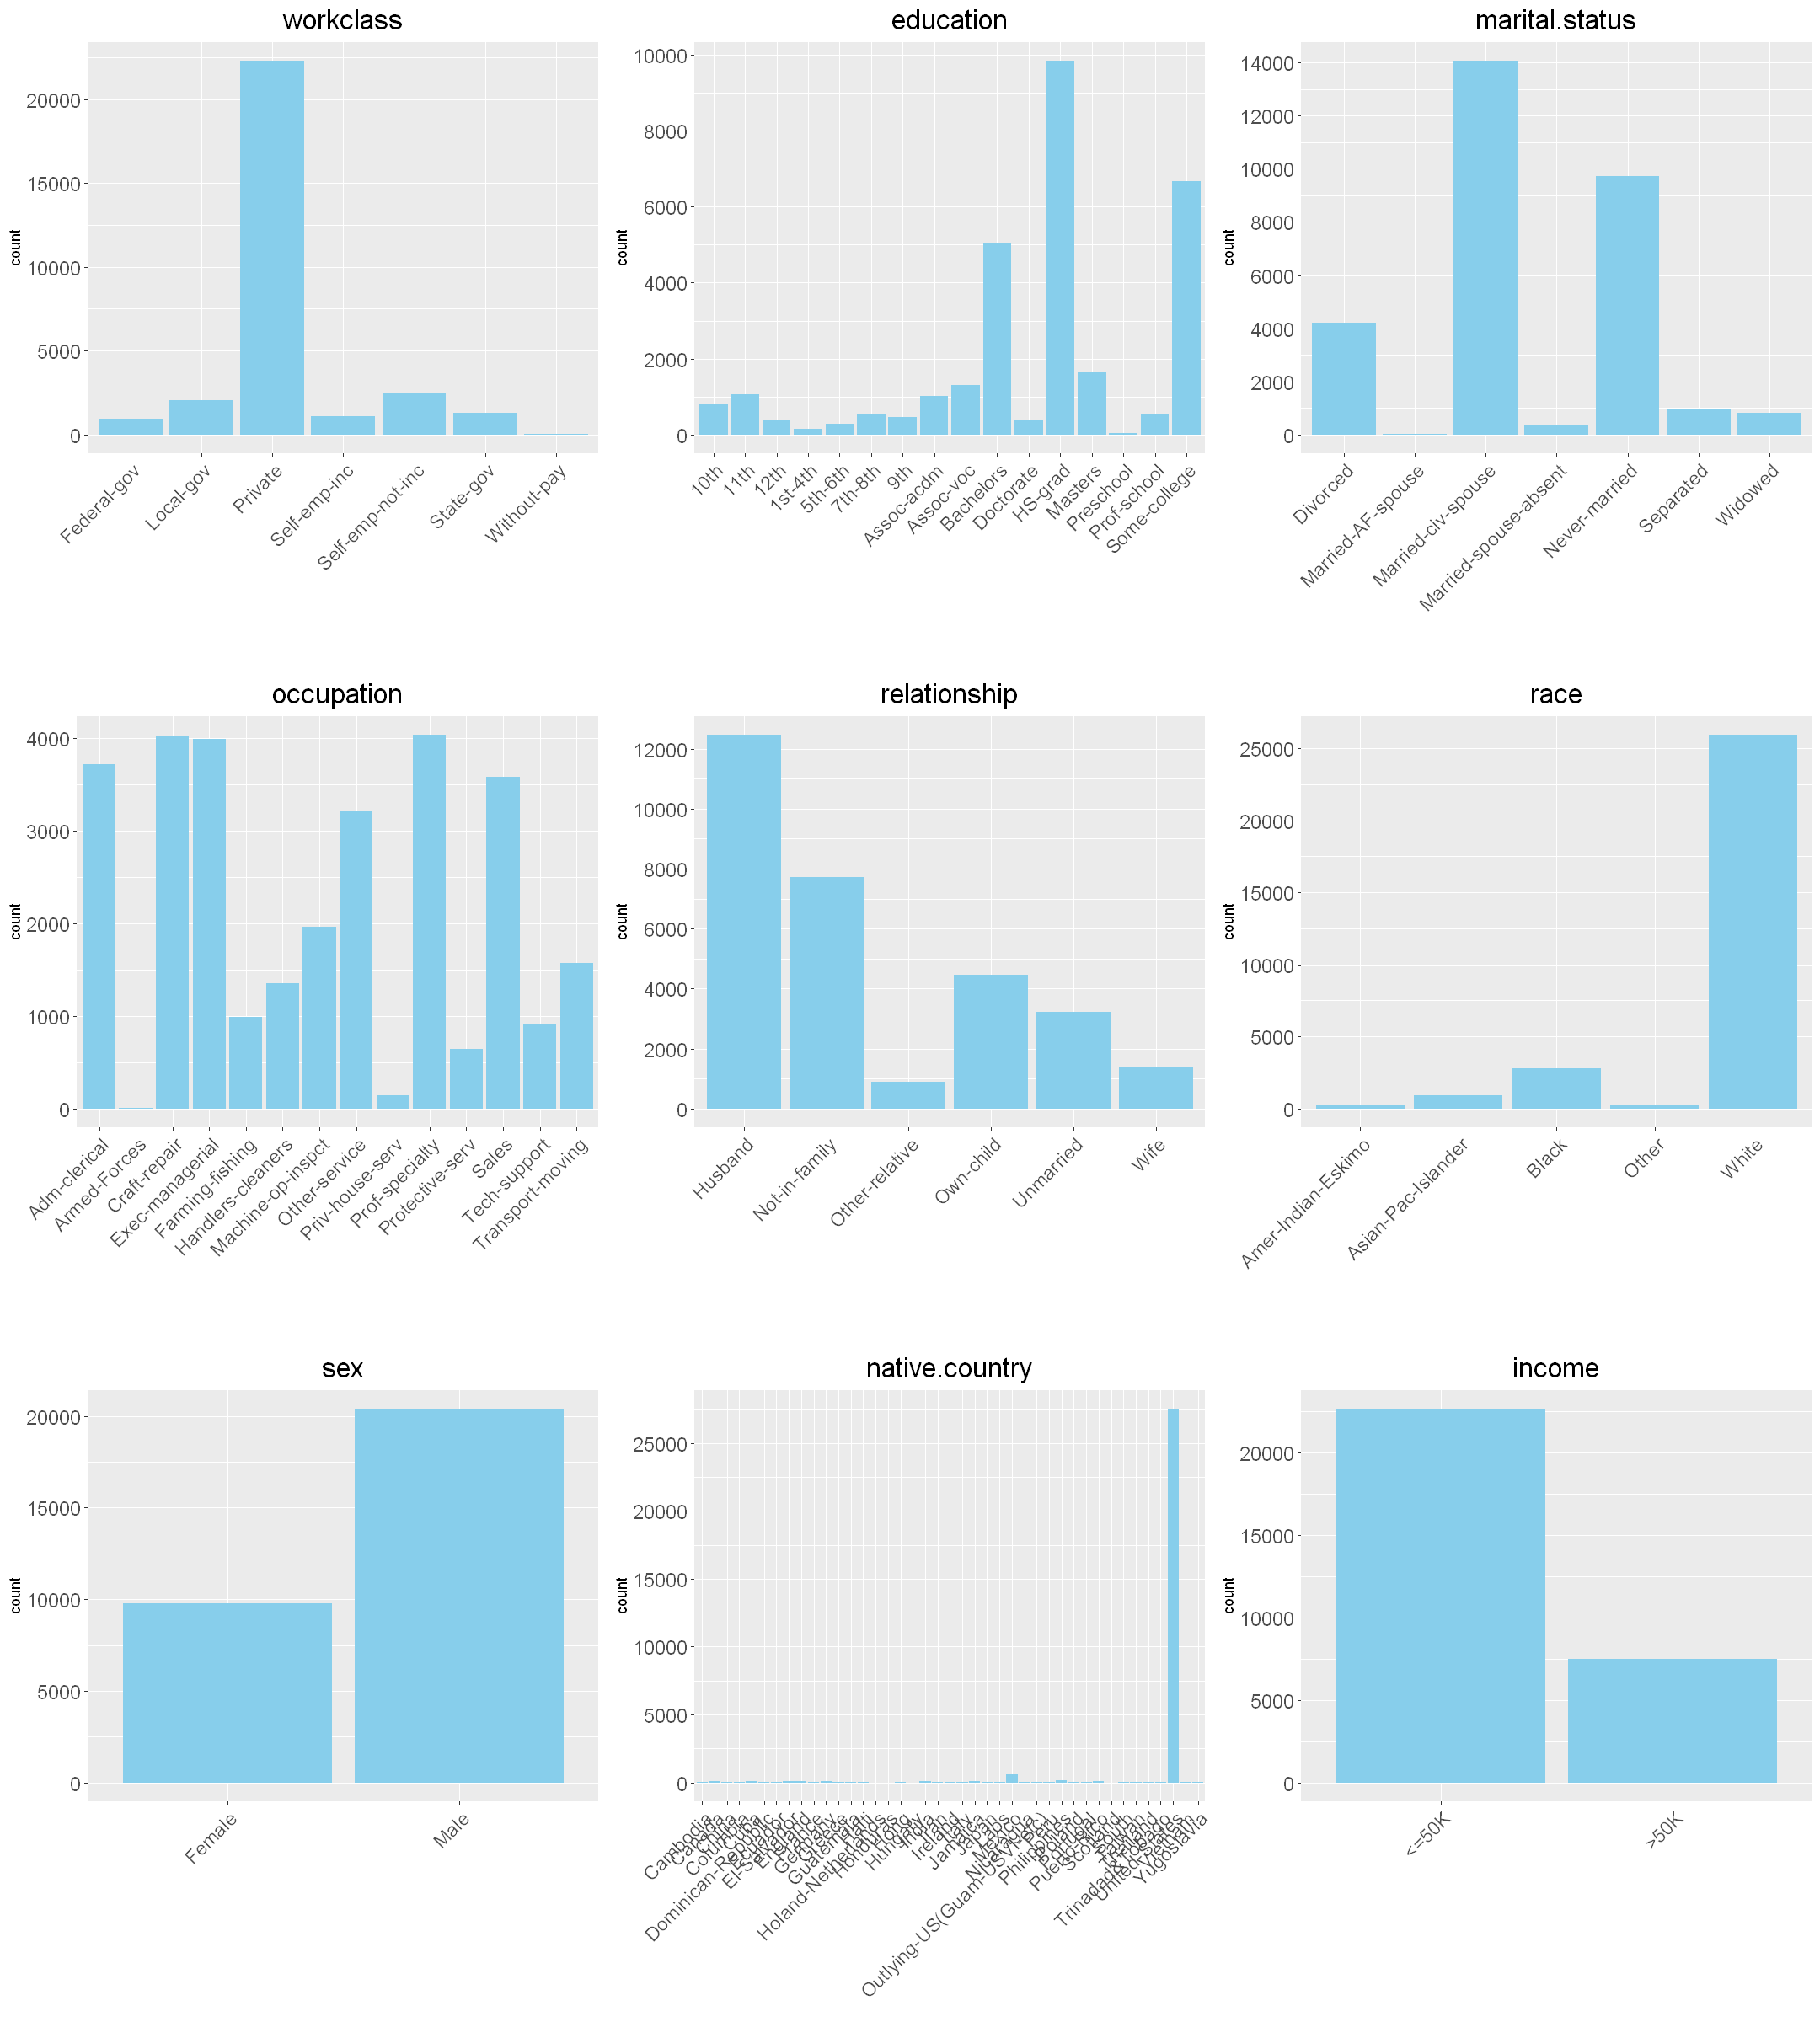

In [33]:
plot_grid1

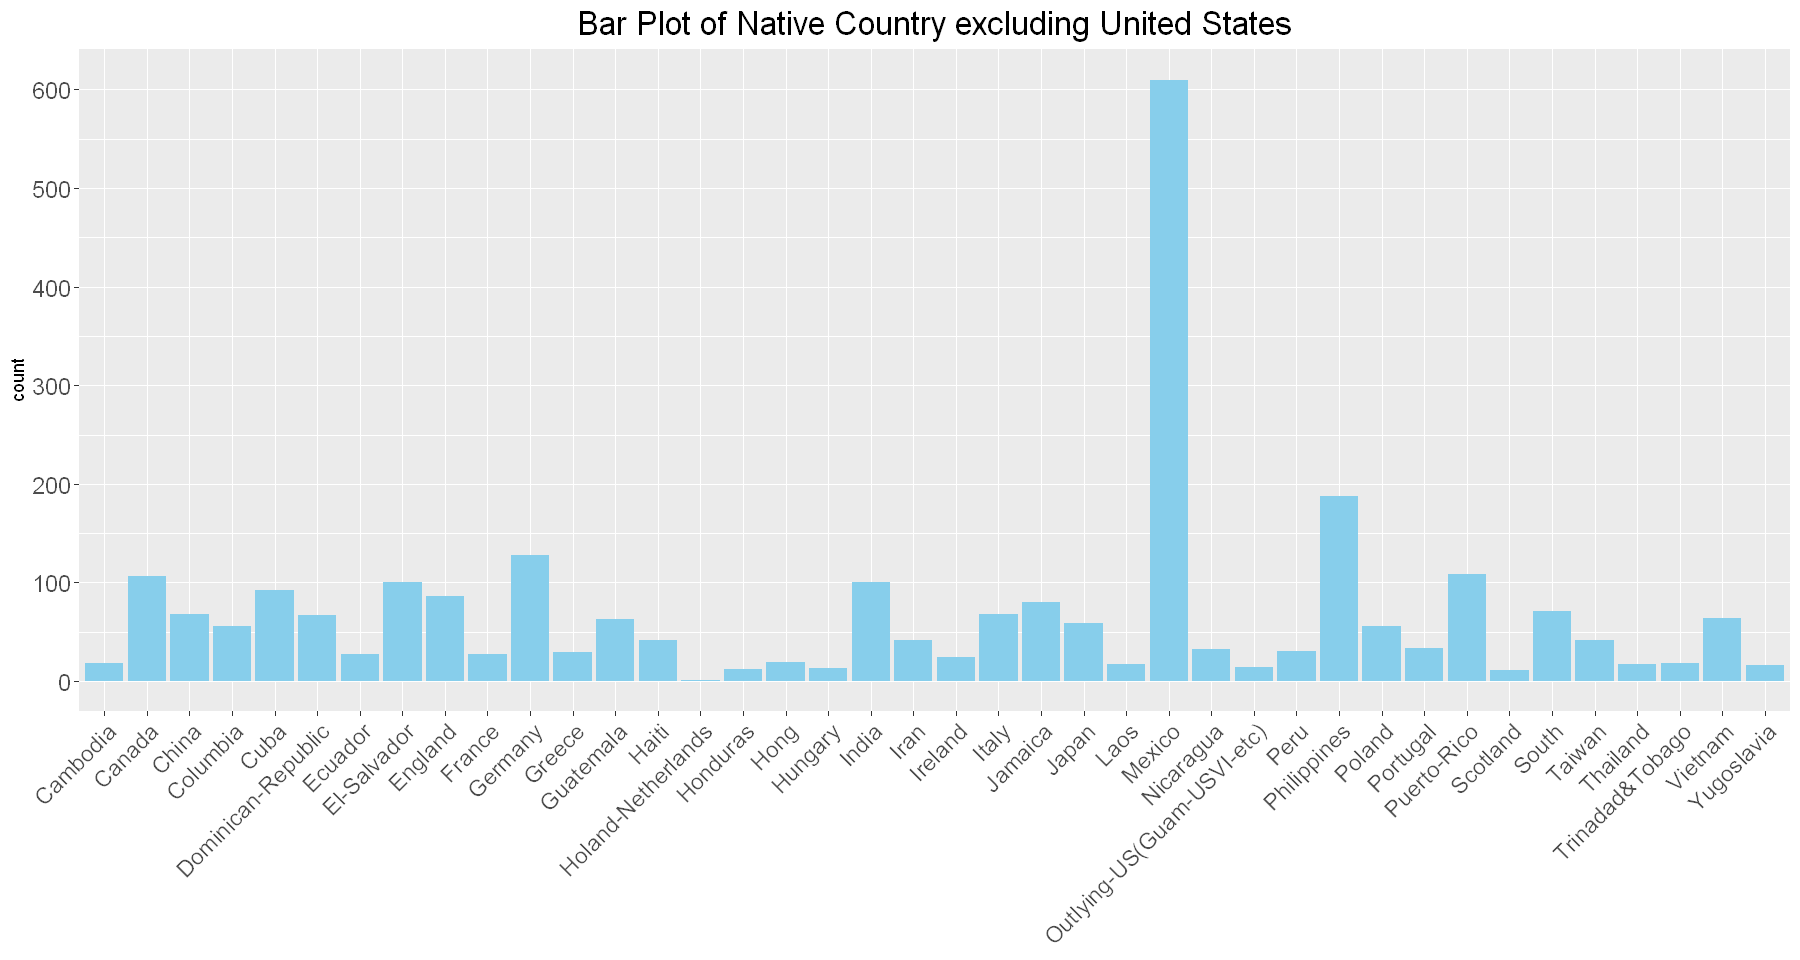

In [35]:
options(repr.plot.width=15, repr.plot.height=8)
country_barplot <- ggplot(subset(clean_data, native.country != "United-States"), aes(x = native.country)) +
  geom_bar(fill='skyblue') +
  labs(title = "Bar Plot of Native Country excluding United States") +
  scale_y_continuous(breaks = pretty_breaks(n = 7)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size=14),
        axis.text.y = element_text(size=14),
        axis.title.x = element_blank(),
        plot.title = element_text(hjust = 0.5, size=20))
country_barplot
ggsave("images/country_barplot.jpg", country_barplot, width = 15, height = 8, units = "in", dpi = 300)

In [36]:
mean(clean_data$native.country == "Mexico") * 100

[1] 2.022479

In [37]:
#how many percent of native.country data is united-states
mean(clean_data$native.country == 'United-States', na.rm = TRUE) * 100

[1] 91.18729

In [38]:
mean(clean_data$workclass == "Private") * 100

[1] 73.89012

In [39]:
mean(clean_data$race == "White") * 100

[1] 85.97858

#### Histograms

In [40]:
histograms <- lapply(numerical_columns, function(column) {
  ggplot(clean_data, aes_string(x = column)) +
    geom_histogram(bins = 30, fill = 'skyblue', color ='#476E7D', size = 0.6) +
    labs(title = column) +
    scale_y_continuous(breaks = pretty_breaks(n = 6)) +
    scale_x_continuous(breaks = pretty_breaks(n=8)) + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1, size=14),
          axis.text.y = element_text(size=14),
          axis.title.x = element_blank(),
          plot.title = element_text(hjust = 0.5, size=20))
})

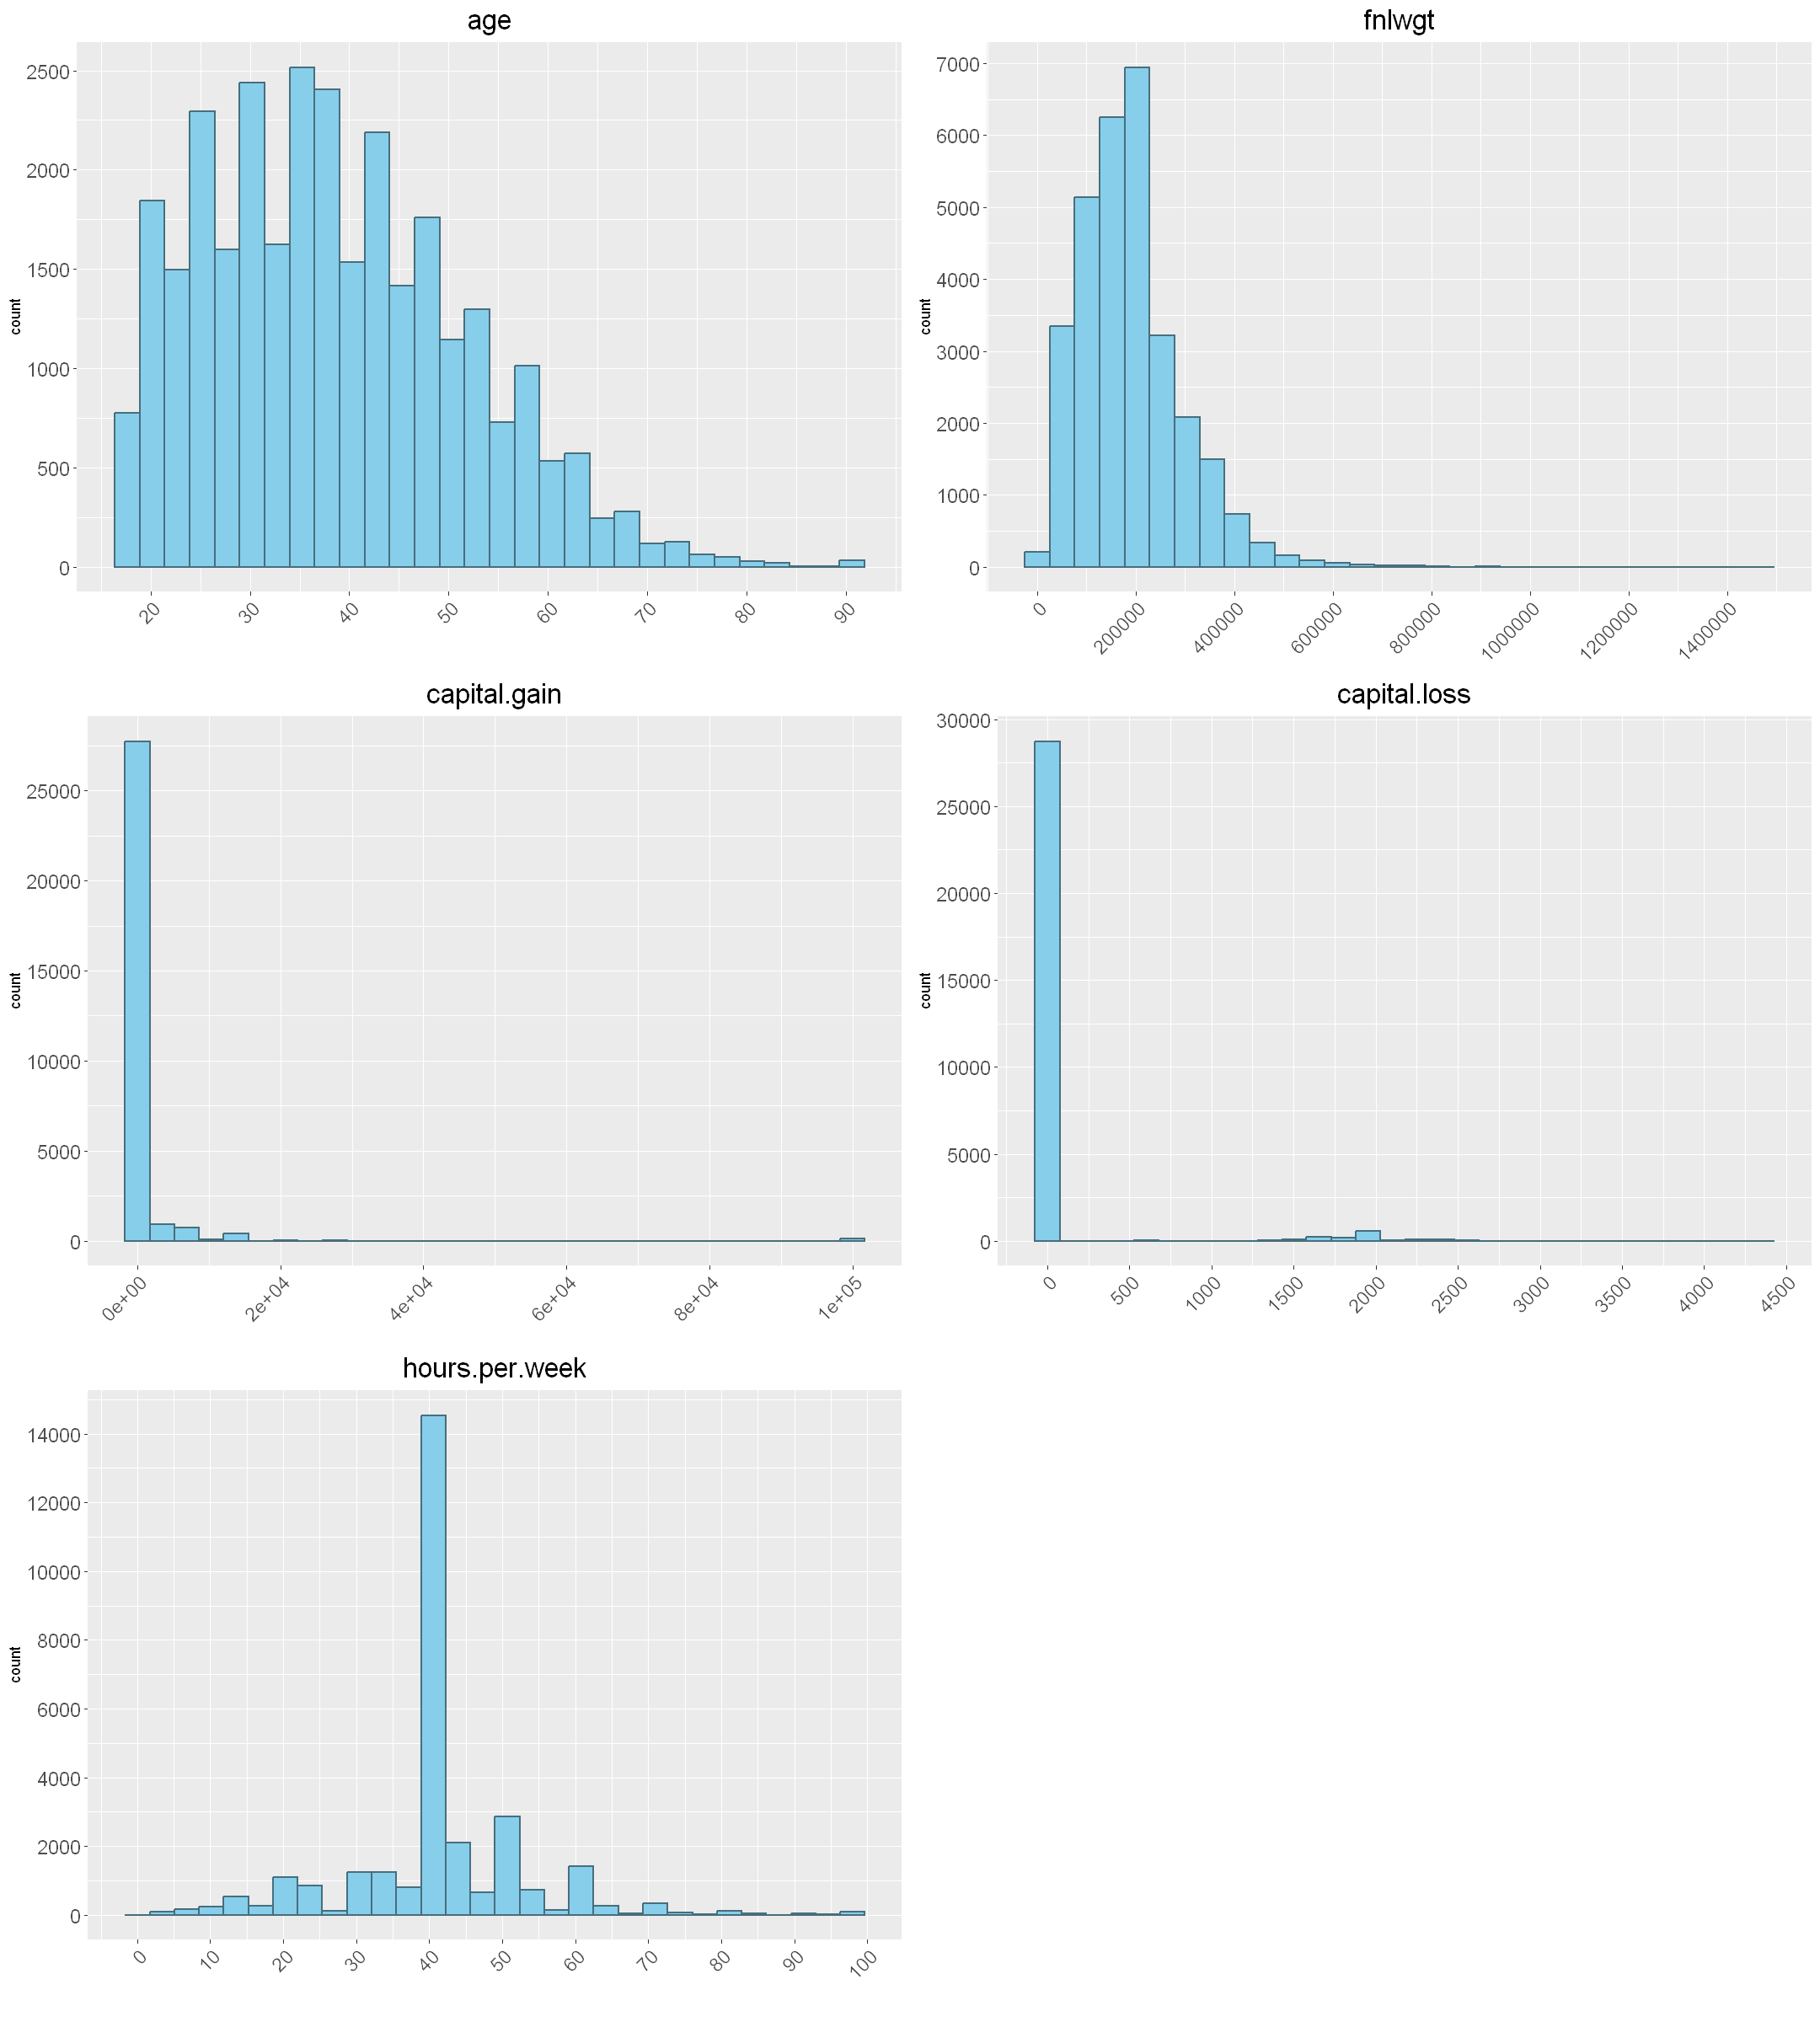

In [41]:
options(repr.plot.width=18, repr.plot.height=20)
hist1 <- plot_grid(plotlist = histograms, ncol = 2, align = "h")
hist1
ggsave("images/histograms1.jpg", hist1, width = 18, height = 20, units = "in", dpi = 300)

#### Boxplots

In [42]:
boxplots <- lapply(c('age', 'fnlwgt', 'hours.per.week'), function(column) {
  ggplot(clean_data, aes_string(y = column)) +
    geom_boxplot(fill = "skyblue", color = "#476E7D") +
    labs(title = paste(column)) +
    scale_y_continuous(breaks = pretty_breaks(n = 10)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, size=14),
          axis.text.y = element_text(size=14),
          axis.title.y = element_text(size=14),
          axis.title.x = element_blank(),
          plot.title = element_text(hjust = 0.5, size=20))
})

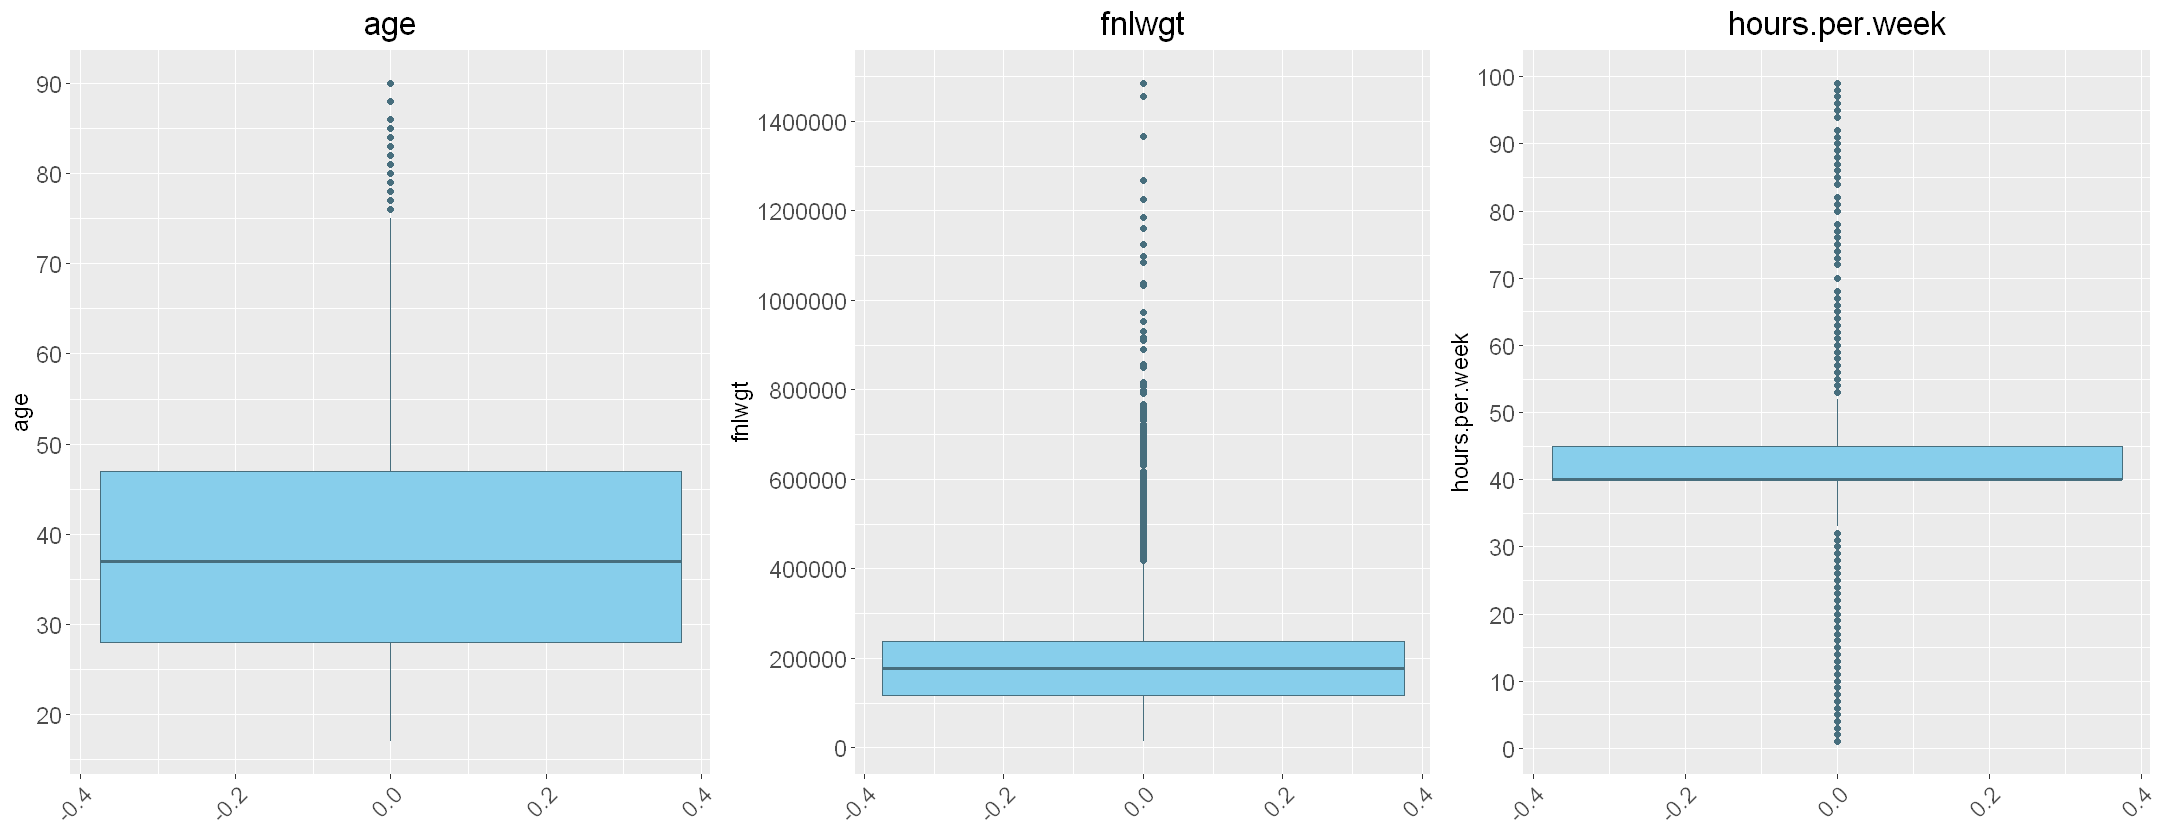

In [43]:
options(repr.plot.width=18, repr.plot.height=7)
boxplots1 <- plot_grid(plotlist = boxplots, ncol = 3, align = "h")
boxplots1
ggsave("images/boxplots1.jpg", boxplots1, width = 18, height = 7, units = "in", dpi = 300)

### Looking for dependencies

We have sometimes 99 hours worked per week. A litte bit too much. But maybe in some private companies or in hospital? Let's check relationship of hours per week worked and occupation.

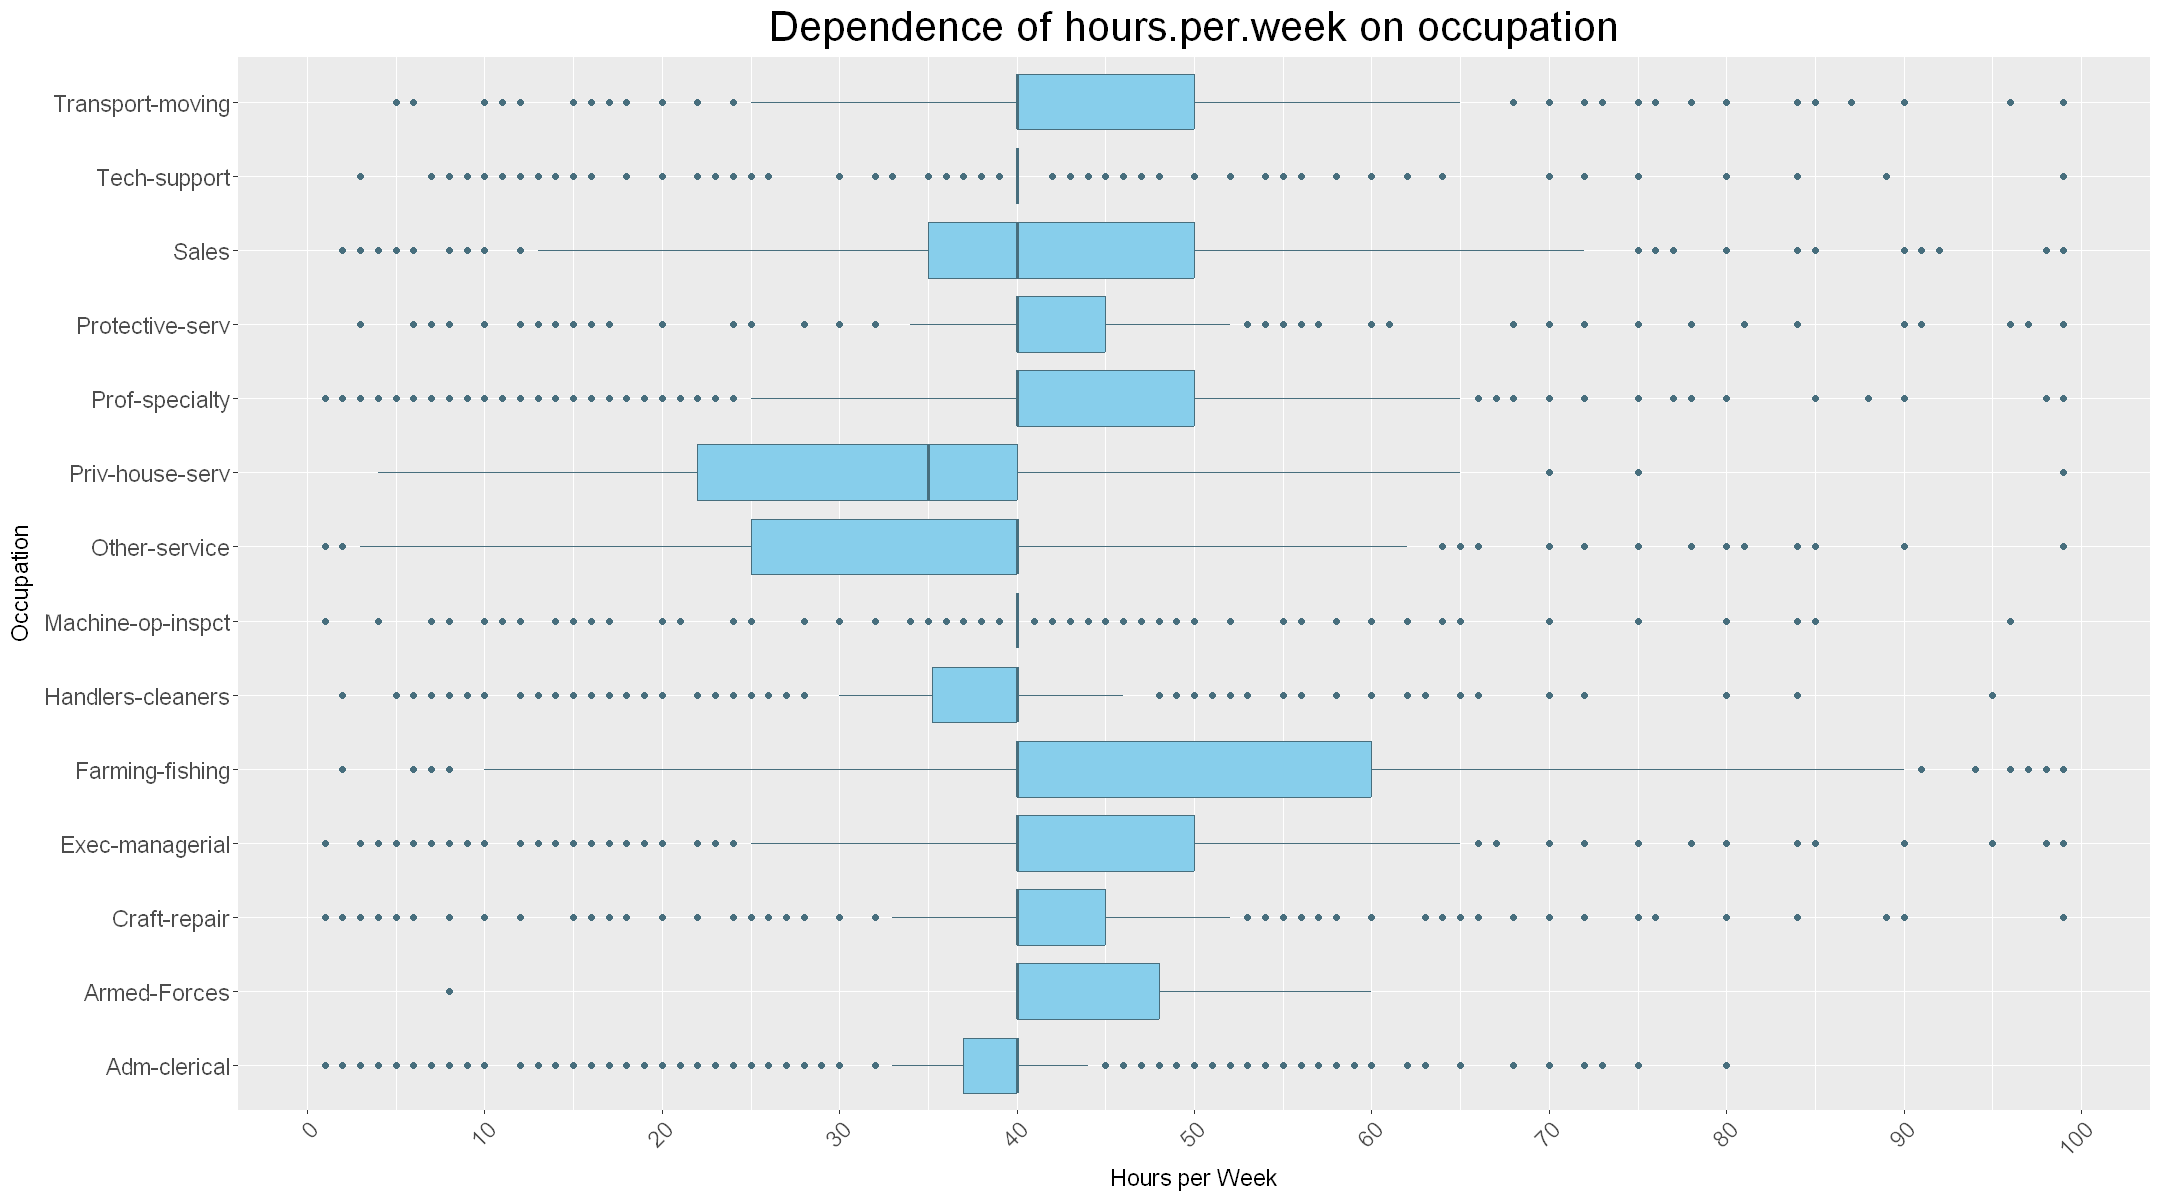

In [137]:
options(repr.plot.width=18, repr.plot.height=10)
hours_occup <- ggplot(clean_data, aes(x = occupation, y = hours.per.week)) +
geom_boxplot(fill = 'skyblue', color = "#476E7D") +
coord_flip() + 
scale_y_continuous(breaks = pretty_breaks(n = 10)) +
labs(title = "Dependence of hours.per.week on occupation", x = "Occupation", y = "Hours per Week") +
theme(axis.text.x = element_text(angle = 45, hjust = 1, size=14),
      axis.text.y = element_text(size=14),
      axis.title.y = element_text(size=14),
      axis.title.x = element_text(size=14),
      plot.title = element_text(hjust = 0.5, size=25))
hours_occup
ggsave("images/hours_occupation.jpg", hours_occup, width = 18, height = 10, units = "in", dpi = 300)

In [45]:
clean_data <- clean_data %>%
  mutate(age_group = cut(age, breaks = c(0, 10, 20, 30, 40, 50, 60, 70, 80, 90), labels = c("0-10", "11-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81-90")))

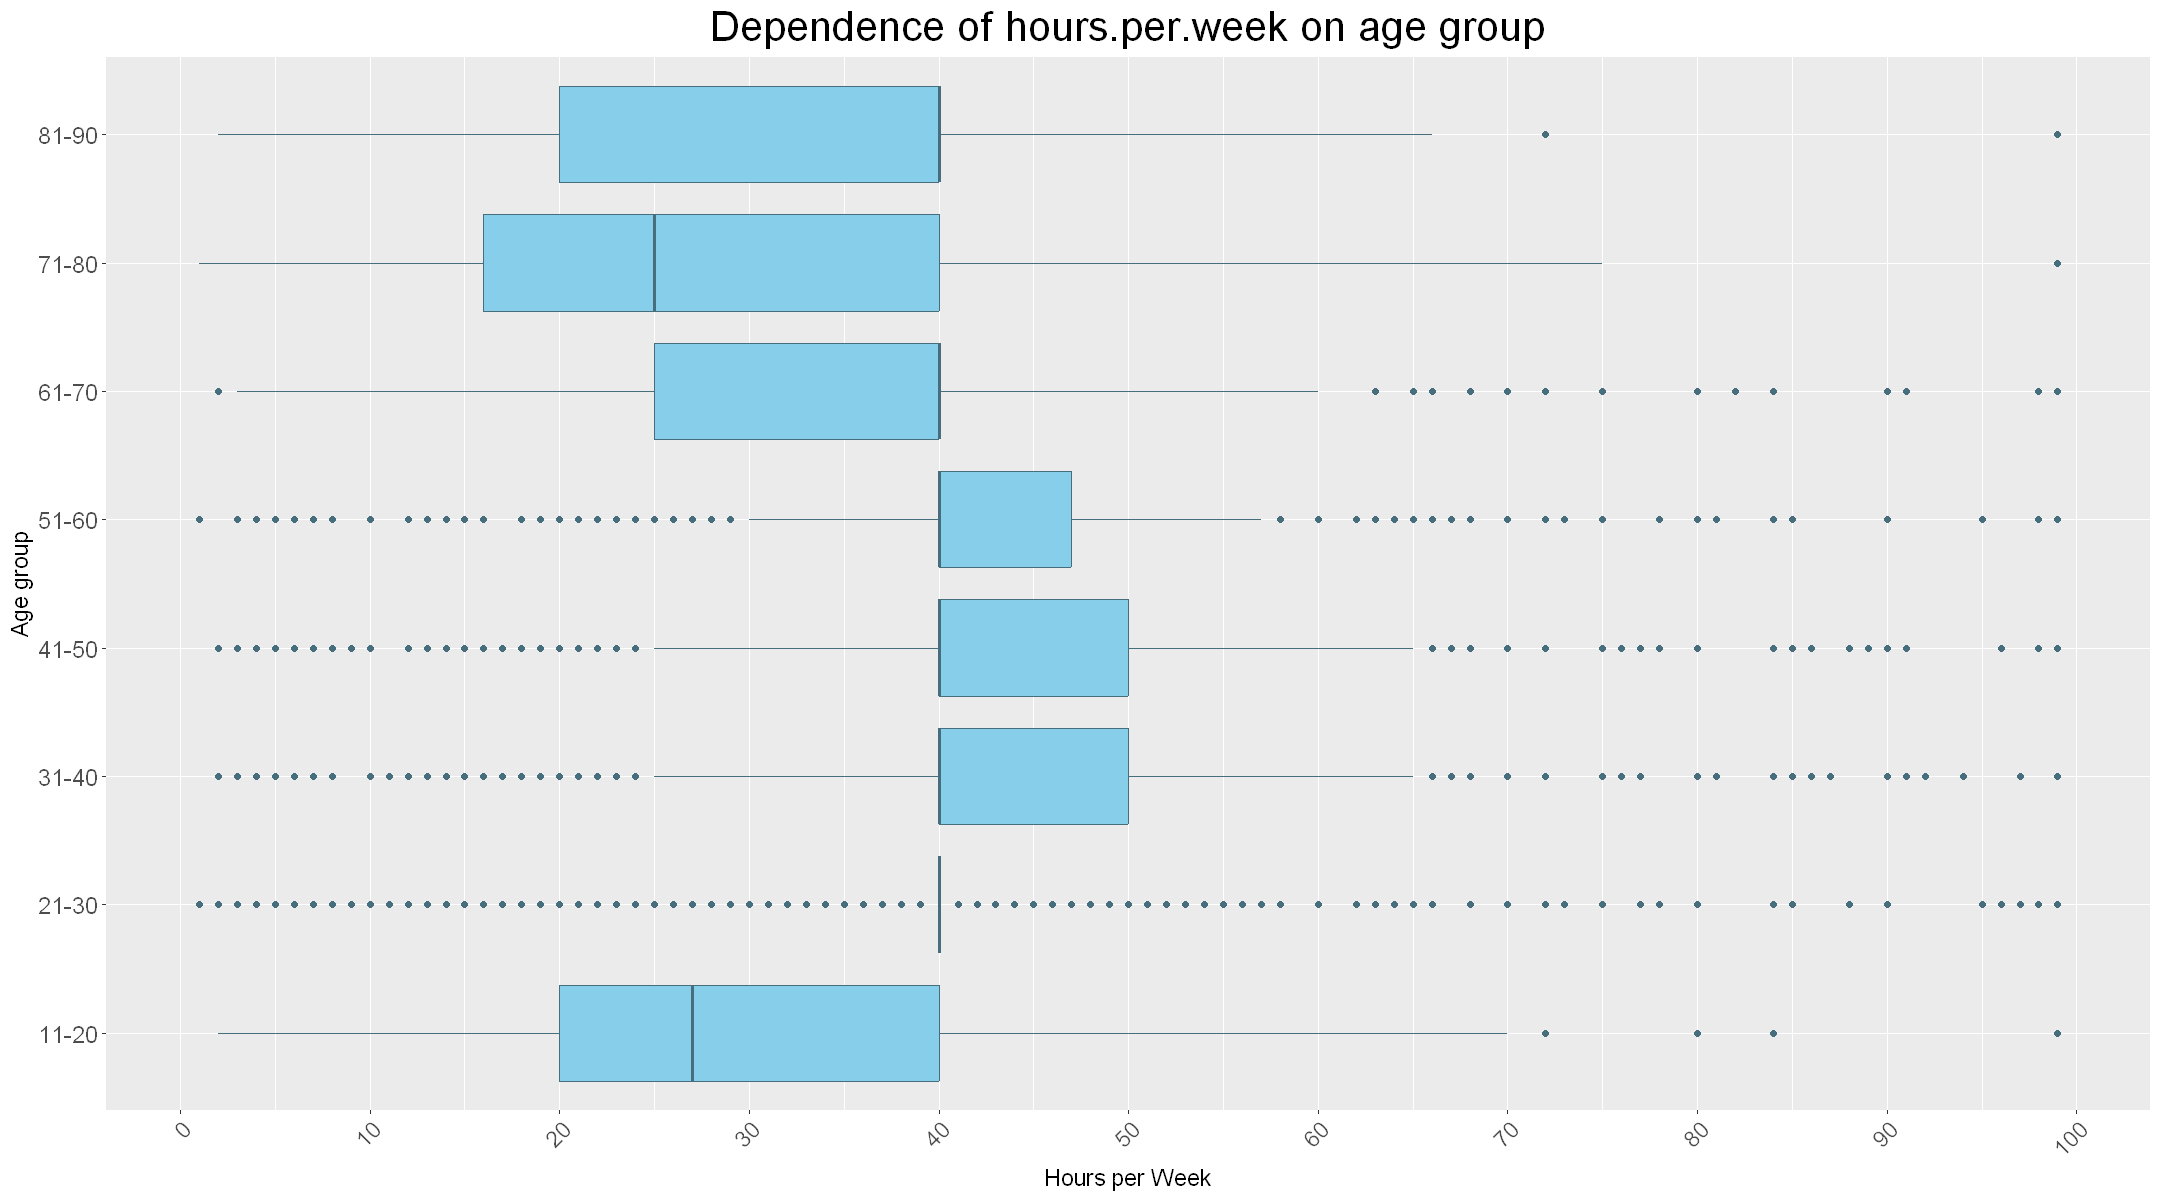

In [138]:
hours_age <- ggplot(clean_data, aes(x = age_group, y = hours.per.week)) +
geom_boxplot(fill = 'skyblue', color = "#476E7D") +
coord_flip() + 
scale_y_continuous(breaks = pretty_breaks(n = 10)) +
labs(title = "Dependence of hours.per.week on age group", x = "Age group", y = "Hours per Week") +
theme(axis.text.x = element_text(angle = 45, hjust = 1, size=14),
      axis.text.y = element_text(size=14),
      axis.title.y = element_text(size=14),
      axis.title.x = element_text(size=14),
      plot.title = element_text(hjust = 0.5, size=25))
hours_age
ggsave("images/hours_age.jpg", hours_age, width = 18, height = 10, units = "in", dpi = 300)

#### Check what is capital gain and loss

In [47]:
cor(clean_data$capital.gain, clean_data$capital.loss)

[1] -0.0322283

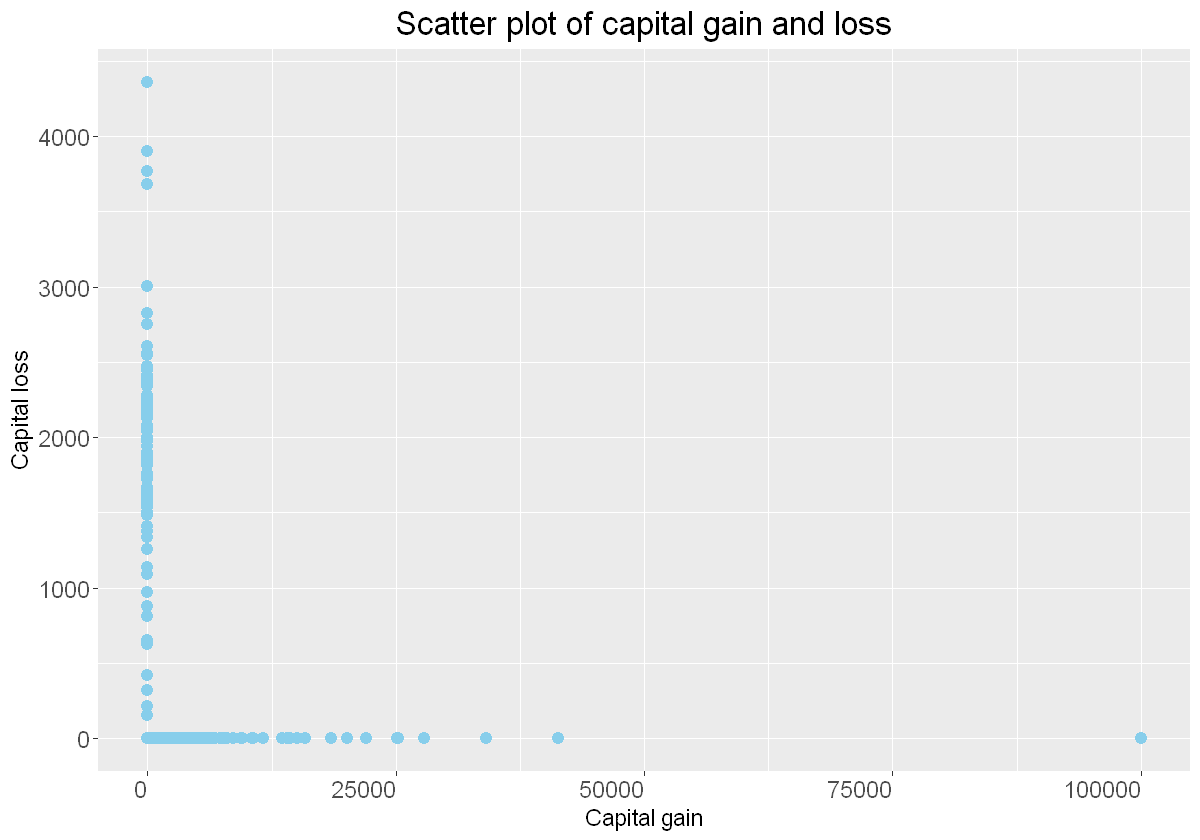

In [136]:
options(repr.plot.width=10, repr.plot.height=7)
capitals <- ggplot(clean_data, aes(x = capital.gain, y = capital.loss)) +
  geom_point(color='skyblue', size = 3) +
  labs(x = "Capital gain", y = "Capital loss",
       title = "Scatter plot of capital gain and loss") +
  theme(axis.text = element_text(hjust = 1, size=14),
        axis.title = element_text(size=14),
        plot.title = element_text(hjust = 0.5, size=20))
capitals
ggsave("images/capitals.jpg", capitals, width = 10, height = 7, units = "in", dpi = 300)

In [49]:
sum(clean_data$capital.gain == 0)
sum(clean_data$capital.loss == 0)

[1] 27624

[1] 28734

In [50]:
sum(clean_data$capital.gain == 0 & clean_data$capital.loss == 0)

[1] 26197

In [51]:
sum(clean_data$capital.gain == 0 & clean_data$capital.loss > 0)
sum(clean_data$capital.loss == 0 & clean_data$capital.gain > 0)

[1] 1427

[1] 2537

In [52]:
26197+1427+2537
nrow(clean_data)

[1] 30161

[1] 30161

#### Correlations

In [54]:
clean_data$income_binary <- ifelse(clean_data$income == ">50K", 1, 0)

correlations <- sapply(clean_data[factor_columns], function(column) {
  cor(clean_data$income_binary, as.numeric(column))
})

correlation_df <- data.frame(Correlation = correlations)

In [55]:
correlation_df

,Correlation
,<dbl>
workclass,0.01810271
education,0.07898137
marital.status,-0.19350425
occupation,0.05155078
relationship,-0.25100947
race,0.07166552
sex,0.21671482
native.country,0.02327335
income,1.00000000


In [56]:
correlations_numerical <- sapply(clean_data[numerical_columns], function(column) {
  cor(clean_data$income_binary, column)
})

correlation_numerical_df <- data.frame(Correlation = correlations_numerical)

In [57]:
correlation_numerical_df

,Correlation
,<dbl>
age,0.242000290
fnlwgt,-0.008977925
capital.gain,0.221200297
capital.loss,0.150050079
hours.per.week,0.229479930


In [104]:
correlation_matrix <- cor(clean_data[sapply(clean_data, is.numeric)])
correlation_data <- reshape2::melt(correlation_matrix)

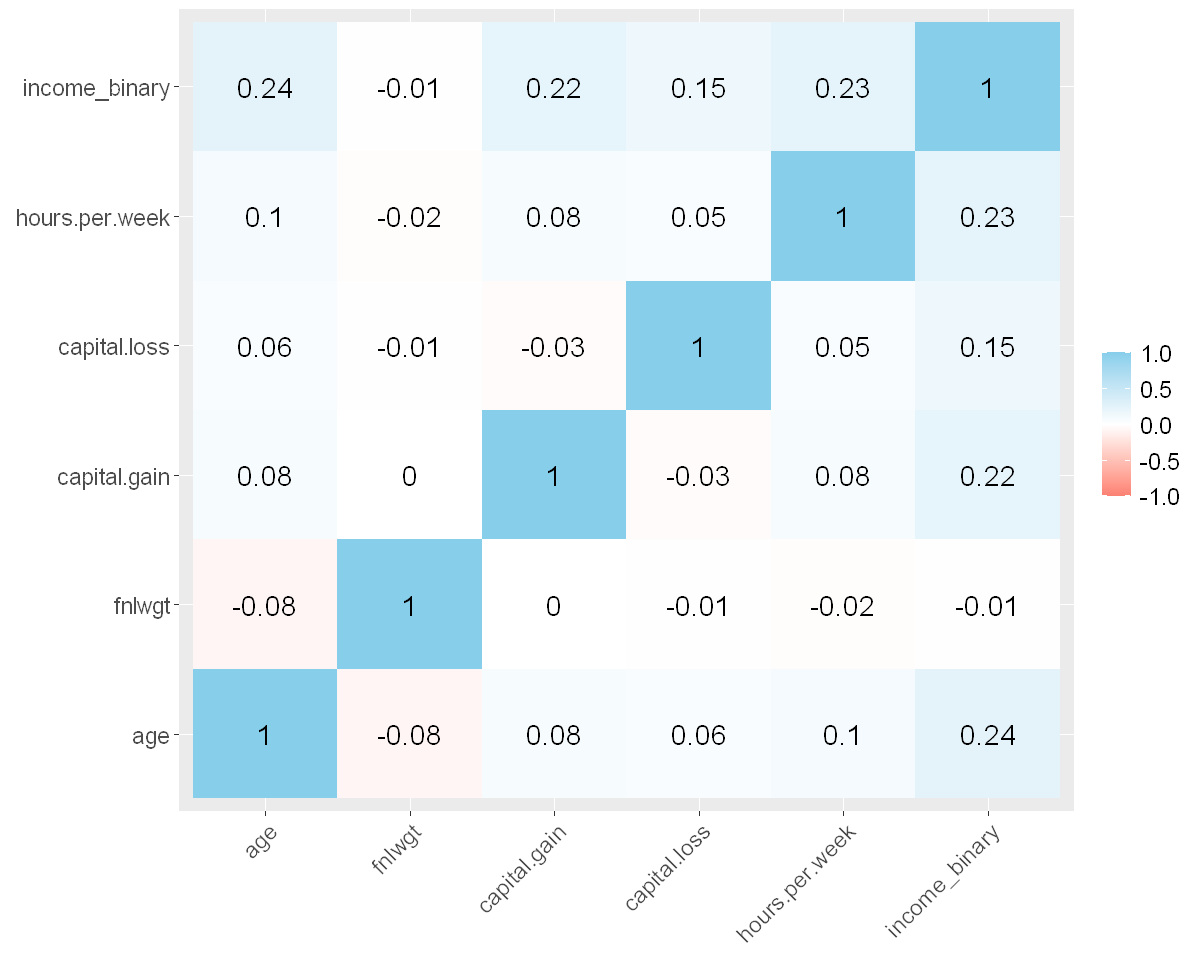

In [150]:
options(repr.plot.width=10, repr.plot.height=8)
corr_matrix <- ggplot(data = correlation_data, aes(x = Var1, y = Var2, fill = value)) +
  geom_tile() +
  scale_fill_gradient2(low = "#FA8072", mid = "white", high = "#87CEEB",
                       midpoint = 0, limits = c(-1, 1), name = "") +
  geom_text(aes(label = round(value, 2)), size = 6) + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size=14),  
        axis.text.y = element_text(size = 14),  
        axis.title = element_blank(),
        legend.position = "right",
        legend.text = element_text(size = 14))  
corr_matrix
ggsave("images/corr_matrix.jpg", corr_matrix, width = 10, height = 8, units = "in", dpi = 300)

In [106]:
cramer_v <- function(x, y) {
  cm <- table(x, y)
  n <- sum(cm)
  r <- nrow(cm)
  k <- ncol(cm)
  
  chi2 <- chisq.test(cm)$statistic
  chi2corr <- max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
  
  kcorr <- k - (k - 1)^2 / (n - 1)
  rcorr <- r - (r - 1)^2 / (n - 1)
  
  return(sqrt(chi2corr / n) / min(kcorr - 1, rcorr - 1))
}

In [148]:
factor_columns_names <- names(clean_data)[sapply(clean_data, is.factor)]

results <- matrix(NA, nrow = length(factor_column_names), ncol = length(factor_column_names))
rownames(results) <- colnames(results) <- factor_column_names

for (i in 1:(length(factor_column_names) - 1)) {
  for (j in (i + 1):length(factor_column_names)) {
    results[i, j] <- results[j, i] <- cramer_v(clean_data[[i]], clean_data[[j]])
  }
}

heatmap_df <- melt(results)


cramer_heatmap <- ggplot(heatmap_df, aes(Var1, Var2, fill = value)) +
  geom_tile(color = "white") +
  geom_text(aes(label = round(value, 2)), size=6,  color = "black") +
  scale_fill_gradient(low = "white", high = "skyblue") +
  labs(title = "",
       x = "",
       y = "") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size=14),  
        axis.text.y = element_text(size = 14),  
        axis.title = element_blank(),
        legend.position = "right",
        legend.text = element_text(size = 14))  

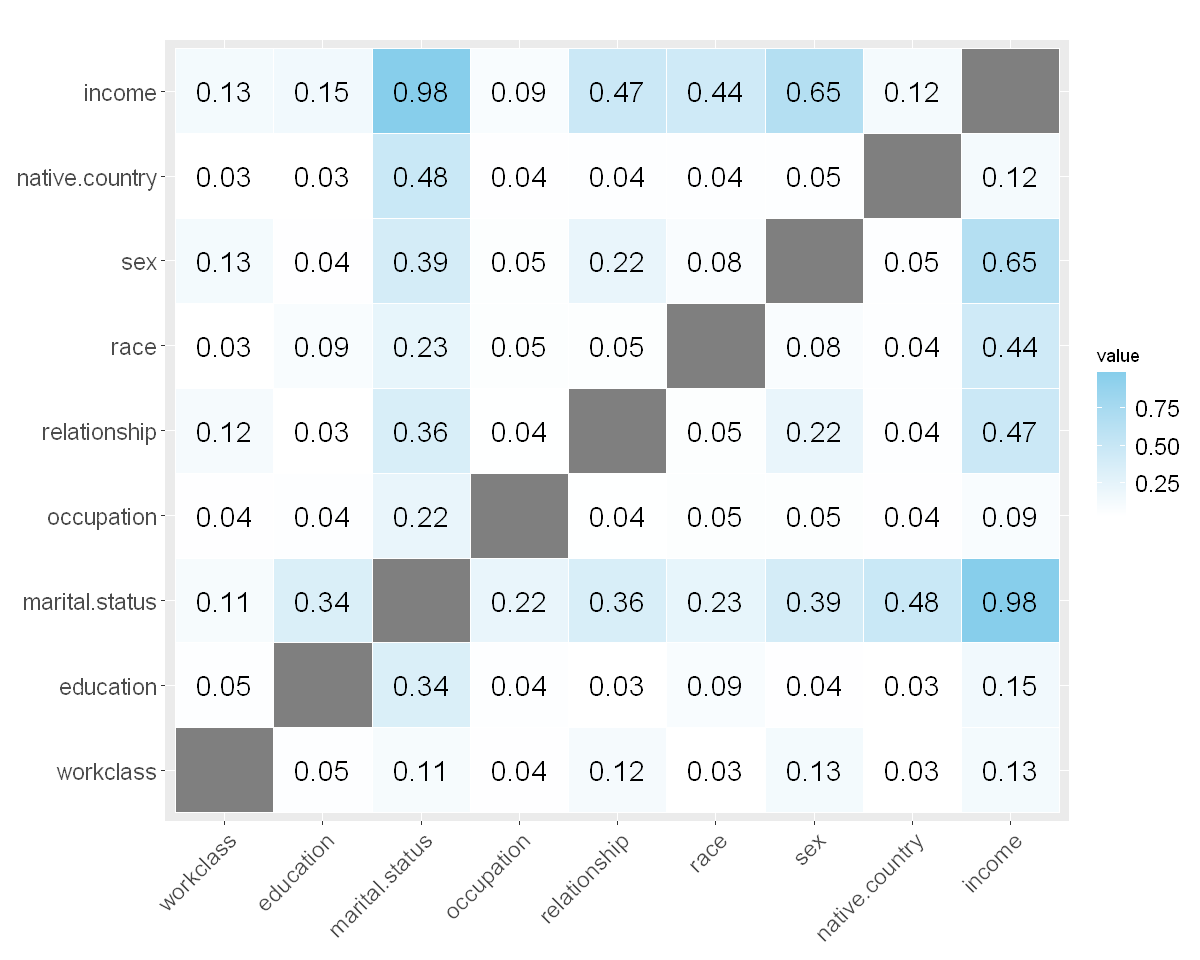

In [149]:
cramer_heatmap
ggsave("images/cramer_heatmap.jpg", cramer_heatmap, width = 10, height = 8, units = "in", dpi = 300)

### Focus on income

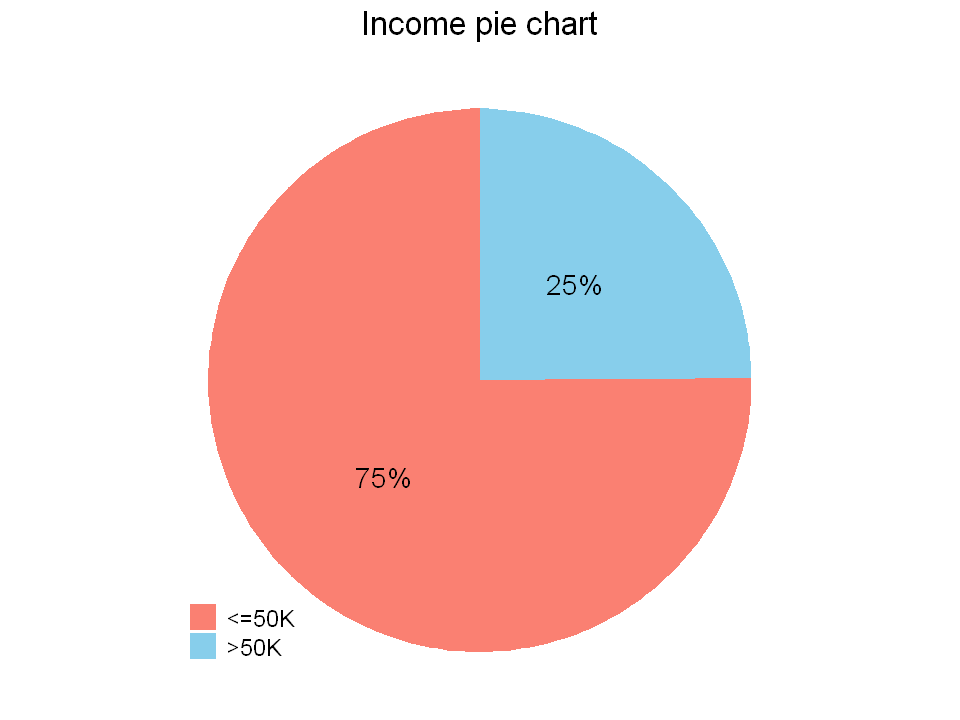

In [183]:
options(repr.plot.width=8, repr.plot.height=6)
pie_income <- ggplot(clean_data, aes(x="", fill=income)) +
    geom_bar(width=1) +
    coord_polar('y') +
    labs(title='Income pie chart', fill="") +
    theme_void() +
    scale_fill_manual(values = c("<=50K" = "salmon", ">50K" = "skyblue")) +
    geom_text(aes(label = paste0(round((..count..)/sum(..count..)*100), "%")),
              stat = "count", position = position_stack(vjust = 0.5), size = 6) +
    theme(legend.position = c(0.15, 0.15),
          plot.title = element_text(hjust = 0.5, size=20),
          legend.text = element_text(size = 14))
pie_income
ggsave("images/pie_income.jpg", pie_income, width = 8, height = 6, units = "in", dpi = 300)

#### Barplots

In [100]:
income_barplots <- lapply(head(factor_columns, -2), function(column) {
  ggplot(clean_data, aes_string(x = column, group = clean_data$income, fill = clean_data$income)) +
    geom_bar(position = 'dodge', aes(y = ..prop..)) +
    labs(title = paste("Income by", column), fill = "") +
    scale_y_continuous(breaks = seq(0, 1, by = 0.1), name = 'percentage') +
    scale_fill_manual(values = c("salmon", "skyblue")) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 14),
          axis.text.y = element_text(size = 14),
          axis.title.x = element_text(size = 14),
          axis.title.y = element_text(size = 14),
          plot.title = element_text(hjust = 0.5, size = 20),
          legend.text = element_text(size = 14),
          legend.position="none")
})

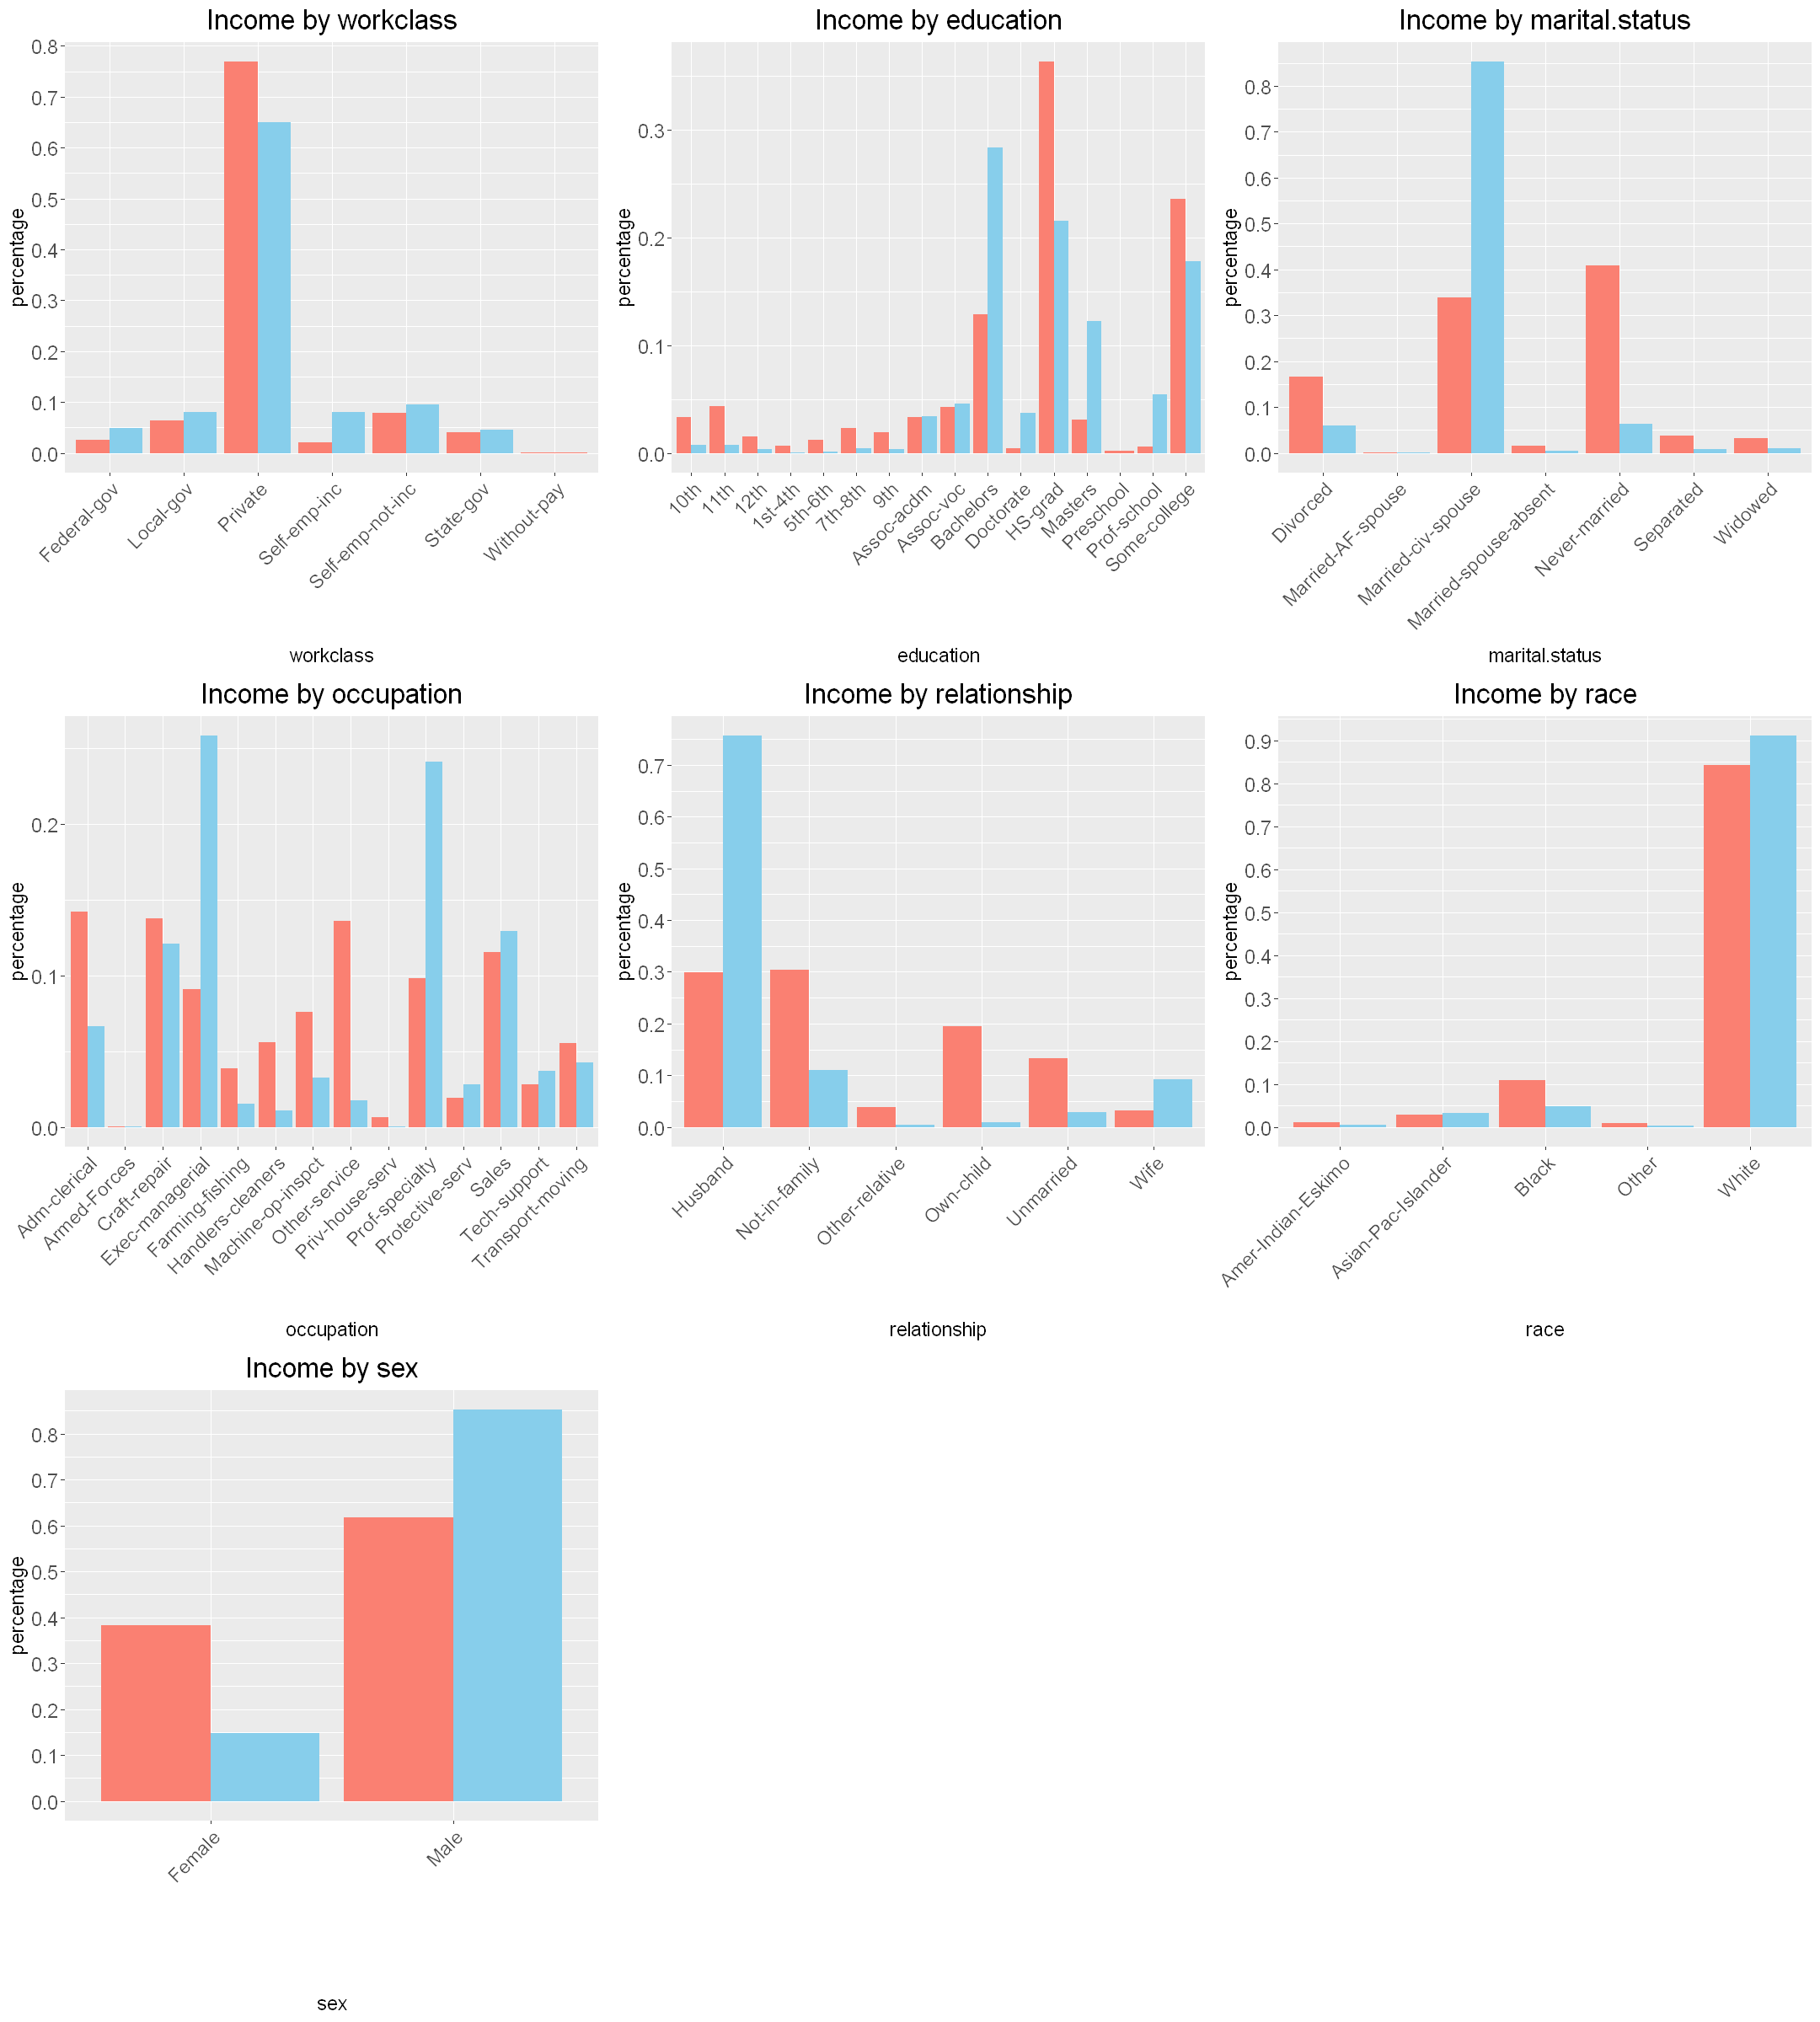

In [101]:
options(repr.plot.width=18, repr.plot.height=20)
income_barplot <- plot_grid(plotlist = income_barplots, ncol = 3, align = "h")
income_barplot
ggsave("images/income_barplots.jpg", income_barplot, width = 18, height = 20, units = "in", dpi = 300)

In [109]:
income_density_by_age <- ggplot(clean_data, aes(x = age, fill = income, color=income)) +
                          geom_density(size=1, alpha=0.9) +
                          labs(title = "Density of Income by Age", x = "Age", y = "Density", fill = "Income", color='Income') +
                          scale_fill_manual(values = c("salmon", "skyblue")) +
                          scale_color_manual(values = c("#9C5048", "#476E7D"), guide = FALSE) +
                          scale_x_continuous(breaks = seq(0, 90, by = 10)) +
                          theme(axis.text.x = element_text(size = 14),
                              axis.text.y = element_text(size = 14),
                              axis.title.x = element_text(size = 14),
                              axis.title.y = element_text(size = 14),
                              plot.title = element_text(hjust = 0.5, size = 20),
                              legend.text = element_text(size = 14),
                              legend.position="none")
income_density_by_hours <- ggplot(clean_data, aes(x = hours.per.week, fill = income, color=income)) +
                          geom_density(size=1, alpha=0.9) +
                          labs(title = "Density of Income by Hours per week", x = "Hours per week", y = "Density", fill = "Income", color='Income') +
                          scale_fill_manual(values = c("salmon", "skyblue")) +
                          scale_color_manual(values = c("#9C5048", "#476E7D"), guide = FALSE) +
                          scale_x_continuous(breaks = seq(0, max(clean_data$hours.per.week), by = 10)) + 
                          theme(axis.text.x = element_text(size = 14),
                              axis.text.y = element_text(size = 14),
                              axis.title.x = element_text(size = 14),
                              axis.title.y = element_text(size = 14),
                              plot.title = element_text(hjust = 0.5, size = 20),
                              legend.text = element_text(size = 14),
                              legend.position="none")

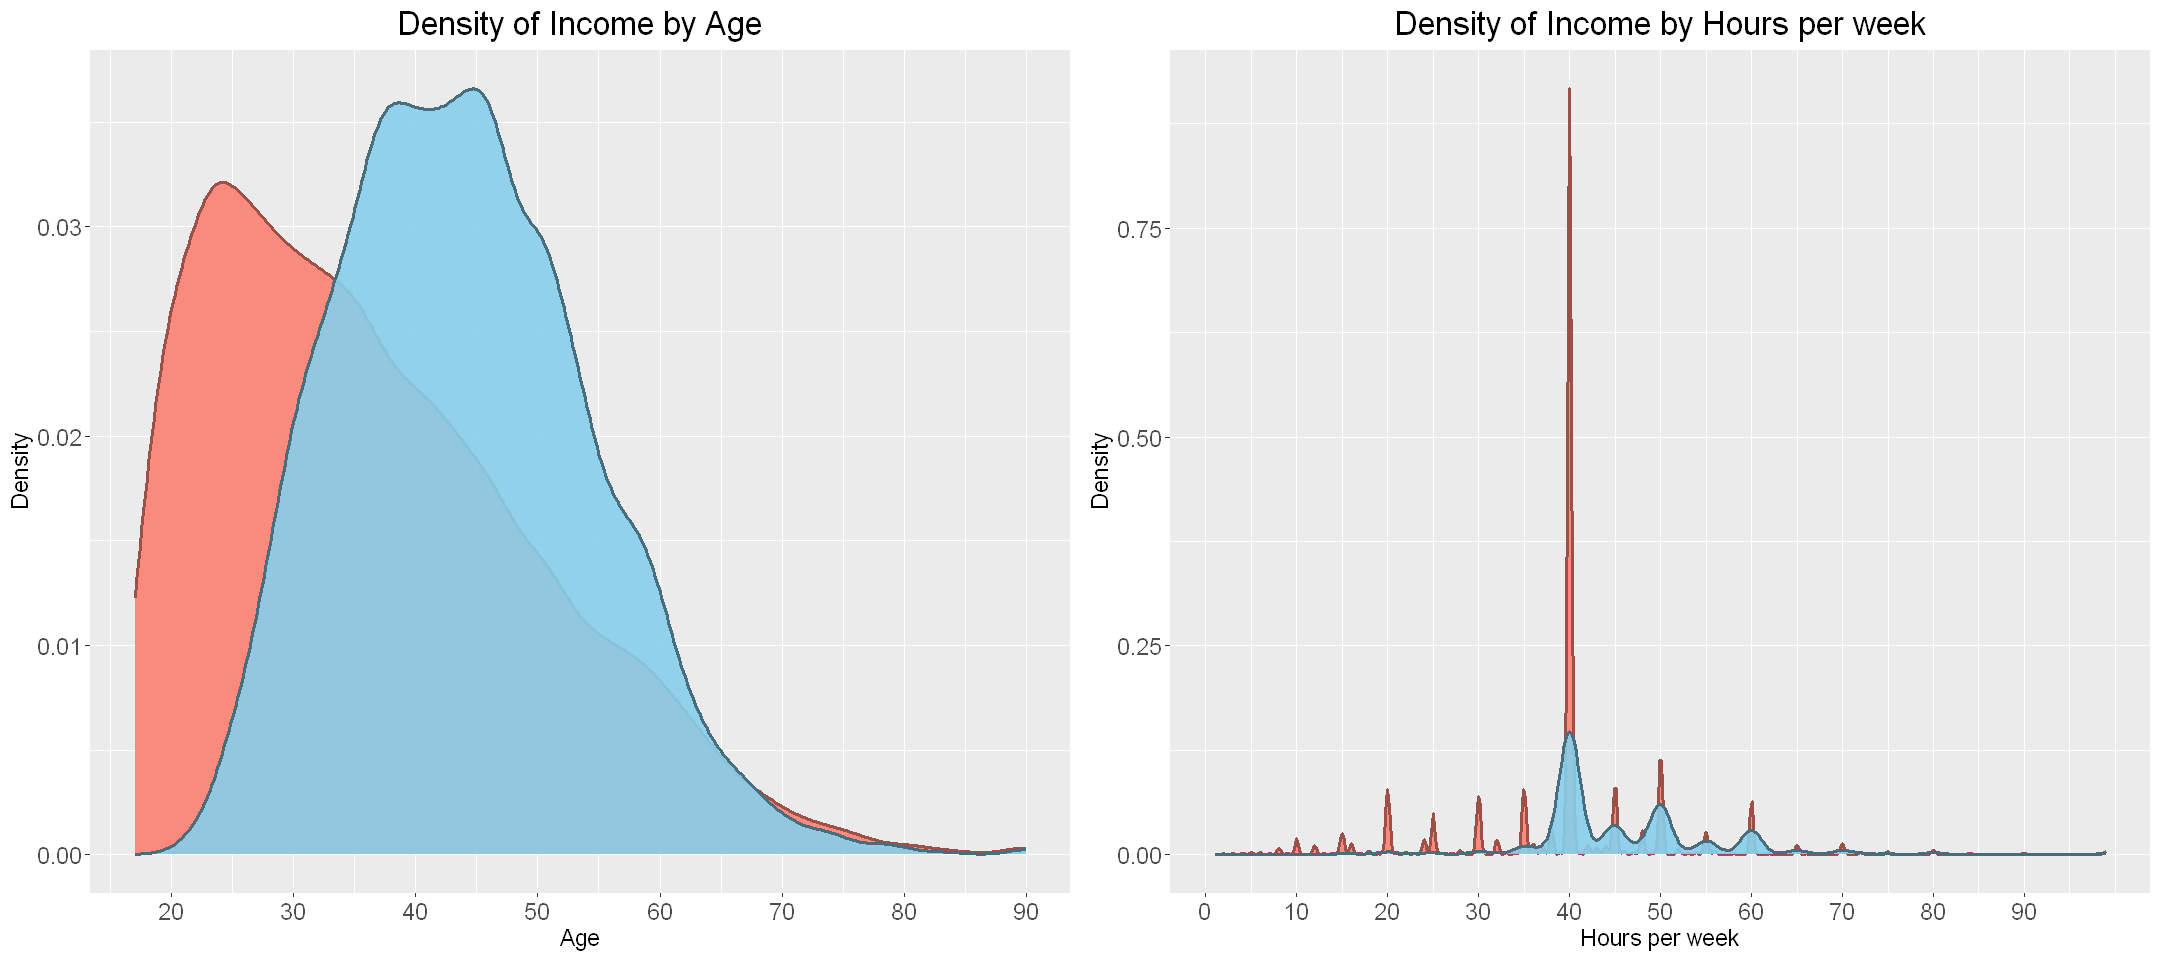

In [110]:
options(repr.plot.width=18, repr.plot.height=8)
income_densities <- plot_grid(income_density_by_age, income_density_by_hours, ncol = 2, align = "h")
income_densities
ggsave("images/income_densitiese.jpg" ,income_densities, width = 18, height = 8, units = "in", dpi = 300)

# Preparation for classification

## Clean data upload

In [288]:
clean_data <- file.path("data", "clean_data.csv")
adult_data <- read.csv(file=clean_data, stringsAsFactors = TRUE, col.names=c("age", "workclass", "fnlwgt", "education", 
                                                       "marital.status", "occupation", "relationship", "race","sex",
                                                       "capital.gain", "capital.loss", "hours.per.week","native.country", "income"))

In [289]:
clean_test <- file.path("data", "clean_test.csv")
adult_test <- read.csv(file=clean_test, stringsAsFactors = TRUE, col.names=c("age", "workclass", "fnlwgt", "education", 
                                                       "marital.status", "occupation", "relationship", "race","sex",
                                                       "capital.gain", "capital.loss", "hours.per.week","native.country", "income"))

In [290]:
prop.table(table(adult_data$income_binary))
prop.table(table(adult_test$income_binary))

numeric(0)

numeric(0)

## Creating new and omitting unnecessary features

In [291]:
adult_data$income_binary <- as.integer(as.numeric(adult_data$income) - 1)
adult_test$income_binary <- as.integer(as.numeric(adult_test$income) - 1)

In [292]:
adult_data <- subset(adult_data, select = -c(income, fnlwgt))
adult_test <- subset(adult_test, select = -c(income, fnlwgt))

In [293]:
adult_data$capital <- as.integer(as.numeric(adult_data$capital.gain) - as.numeric(adult_data$capital.loss))
adult_test$capital <- as.integer(as.numeric(adult_test$capital.gain) - as.numeric(adult_test$capital.loss))

In [294]:
adult_data <- subset(adult_data, select = -c(capital.gain, capital.loss))
adult_test <- subset(adult_test, select = -c(capital.gain, capital.loss))

In [295]:
summary(adult_data$capital)
summary(adult_test$capital)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  -4356       0       0    1004       0   99999 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  -3770       0       0    1031       0   99999 

In [296]:
(adult_data %>% sample_n(5))

age,workclass,education,marital.status,occupation,relationship,race,sex,hours.per.week,native.country,income_binary,capital
<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<int>,<int>
24,Private,Assoc-voc,Married-civ-spouse,Craft-repair,Husband,White,Male,40,United-States,0,0
20,Private,12th,Never-married,Adm-clerical,Own-child,White,Female,40,Mexico,0,0
46,State-gov,HS-grad,Married-civ-spouse,Other-service,Wife,Black,Female,40,United-States,0,0
50,Private,HS-grad,Divorced,Machine-op-inspct,Other-relative,White,Female,48,United-States,0,0
43,Private,7th-8th,Married-civ-spouse,Transport-moving,Husband,Black,Male,40,United-States,0,0


In [297]:
(adult_test %>% sample_n(5))

age,workclass,education,marital.status,occupation,relationship,race,sex,hours.per.week,native.country,income_binary,capital
<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<int>,<int>
67,Private,HS-grad,Divorced,Adm-clerical,Not-in-family,White,Female,15,United-States,0,0
31,Private,Some-college,Married-civ-spouse,Sales,Husband,White,Male,43,United-States,0,0
45,Local-gov,Masters,Married-civ-spouse,Prof-specialty,Husband,White,Male,40,France,1,0
40,Private,Some-college,Married-civ-spouse,Sales,Husband,White,Male,40,United-States,1,5178
47,Private,11th,Never-married,Handlers-cleaners,Own-child,White,Male,40,United-States,0,0


## Add continent column

## training data

In [298]:
adult_data$continent <- countrycode(sourcevar = adult_data[, "native.country"],
                            origin = "country.name",
                            destination = "region")

In [299]:
sum(is.na(adult_data$continent))

[1] 243

In [300]:
unique(adult_data$native.country[is.na(adult_data$continent)])

[1] England  Columbia South    Scotland Hong    
41 Levels: Cambodia Canada China Columbia Cuba Dominican-Republic ... Yugoslavia

In [301]:
country_continent_mapping <- c(England = 'Europe & Central Asia', Scotland = 'Europe & Central Asia', Columbia = 'South America', 
                               Hong = 'South Asia', South = 'South Asia')

In [302]:
adult_data$continent <- ifelse(is.na(adult_data$continent), 
                               country_continent_mapping[adult_data$native.country],
                               adult_data$continent)

In [303]:
adult_data$continent[adult_data$native.country == "England"] <- 'Europe & Central Asia'
adult_data$continent[adult_data$native.country == "Scotland"] <- 'Europe & Central Asia'
adult_data$continent[adult_data$native.country == "Hong"] <- 'South Asia'
adult_data$continent[adult_data$native.country == "South"] <- 'South Asia'

In [304]:
adult_data$continent <- as.factor(adult_data$continent)

In [305]:
str(adult_data)

'data.frame':	30161 obs. of  13 variables:
 $ age           : int  50 38 53 28 37 49 52 31 42 37 ...
 $ workclass     : Factor w/ 7 levels "Federal-gov",..: 5 3 3 3 3 3 5 3 3 3 ...
 $ education     : Factor w/ 16 levels "10th","11th",..: 10 12 2 10 13 7 12 13 10 16 ...
 $ marital.status: Factor w/ 7 levels "Divorced","Married-AF-spouse",..: 3 1 3 3 3 4 3 5 3 3 ...
 $ occupation    : Factor w/ 14 levels "Adm-clerical",..: 4 6 6 10 4 8 4 10 4 4 ...
 $ relationship  : Factor w/ 6 levels "Husband","Not-in-family",..: 1 2 1 6 6 2 1 2 1 1 ...
 $ race          : Factor w/ 5 levels "Amer-Indian-Eskimo",..: 5 5 3 3 5 3 5 5 5 3 ...
 $ sex           : Factor w/ 2 levels "Female","Male": 2 2 2 1 1 1 2 1 2 2 ...
 $ hours.per.week: int  13 40 40 40 40 16 45 50 40 80 ...
 $ native.country: Factor w/ 41 levels "Cambodia","Canada",..: 39 39 39 5 39 23 39 39 39 39 ...
 $ income_binary : int  0 0 0 0 0 0 1 1 1 1 ...
 $ capital       : int  0 0 0 0 0 0 0 14084 5178 0 ...
 $ continent     : Factor w/ 6 lev

## test data

In [306]:
adult_test$continent <- countrycode(sourcevar = adult_test[, "native.country"],
                            origin = "country.name",
                            destination = "region")

In [307]:
sum(is.na(adult_test$continent))

[1] 107

In [308]:
unique(adult_test$native.country[is.na(adult_test$continent)])

[1] South    Columbia England  Scotland Hong    
40 Levels: Cambodia Canada China Columbia Cuba Dominican-Republic ... Yugoslavia

In [309]:
adult_test$continent <- ifelse(is.na(adult_test$continent), 
                               country_continent_mapping[adult_test$native.country],
                               adult_test$continent)

In [310]:
adult_test$continent[adult_test$native.country == "England"] <- 'Europe & Central Asia'
adult_test$continent[adult_test$native.country == "Scotland"] <- 'Europe & Central Asia'
adult_test$continent[adult_test$native.country == "Hong"] <- 'South Asia'
adult_test$continent[adult_test$native.country == "South"] <- 'South Asia'

In [311]:
adult_test$continent <- as.factor(adult_test$continent)

In [312]:
str(adult_test)

'data.frame':	15060 obs. of  13 variables:
 $ age           : int  25 38 28 44 34 63 24 55 65 36 ...
 $ workclass     : Factor w/ 7 levels "Federal-gov",..: 3 3 2 3 3 5 3 3 3 1 ...
 $ education     : Factor w/ 16 levels "10th","11th",..: 2 12 8 16 1 15 16 6 12 10 ...
 $ marital.status: Factor w/ 7 levels "Divorced","Married-AF-spouse",..: 5 3 3 3 5 3 5 3 3 3 ...
 $ occupation    : Factor w/ 14 levels "Adm-clerical",..: 7 5 11 7 8 10 8 3 7 1 ...
 $ relationship  : Factor w/ 6 levels "Husband","Not-in-family",..: 4 1 1 1 2 1 5 1 1 1 ...
 $ race          : Factor w/ 5 levels "Amer-Indian-Eskimo",..: 3 5 5 3 5 5 5 5 5 5 ...
 $ sex           : Factor w/ 2 levels "Female","Male": 2 2 2 2 2 2 1 2 2 2 ...
 $ hours.per.week: int  40 50 40 40 30 32 40 10 40 40 ...
 $ native.country: Factor w/ 40 levels "Cambodia","Canada",..: 38 38 38 38 38 38 38 38 38 38 ...
 $ income_binary : int  0 0 1 1 0 1 0 0 1 0 ...
 $ capital       : int  0 0 0 7688 0 3103 0 0 6418 0 ...
 $ continent     : Factor w/ 6 le

## Checking continents

In [324]:
counts_data <- table(adult_data$continent)
total_count_data <- sum(counts_data)
percentage_by_group <- (counts_data / total_count_data) * 100
percentage_by_group


       East Asia & Pacific      Europe & Central Asia 
                 1.6146679                  1.6345612 
 Latin America & Caribbean Middle East & North Africa 
                 4.2538377                  0.1392527 
             North America                 South Asia 
                91.5420576                  0.8156228 

In [326]:
counts_test <- table(adult_test$continent)
total_count_test <- sum(counts_test)
percentage_by_group_test <- (counts_test / total_count_test) * 100
percentage_by_group_test


       East Asia & Pacific      Europe & Central Asia 
                1.55378486                 1.62682603 
 Latin America & Caribbean Middle East & North Africa 
                4.05710491                 0.09296149 
             North America                 South Asia 
               91.92563081                 0.74369190 

In [348]:
continent_barplot_train <- ggplot(adult_data, aes(x = continent)) +
  geom_bar(fill='skyblue') +
  labs(title = "Bar Plot of Continents regions") +
  scale_y_continuous(breaks = pretty_breaks(n = 7)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size=14),
        axis.text.y = element_text(size=14),
        axis.title.x = element_blank(),
        plot.title = element_text(hjust = 0.5, size=20))

continent_barplot_test <- ggplot(adult_test, aes(x = continent)) +
  geom_bar(fill='skyblue') +
  labs(title = "Bar Plot of Continents regions") +
  scale_y_continuous(breaks = pretty_breaks(n = 7)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size=14),
        axis.text.y = element_text(size=14),
        axis.title.x = element_blank(),
        plot.title = element_text(hjust = 0.5, size=20))

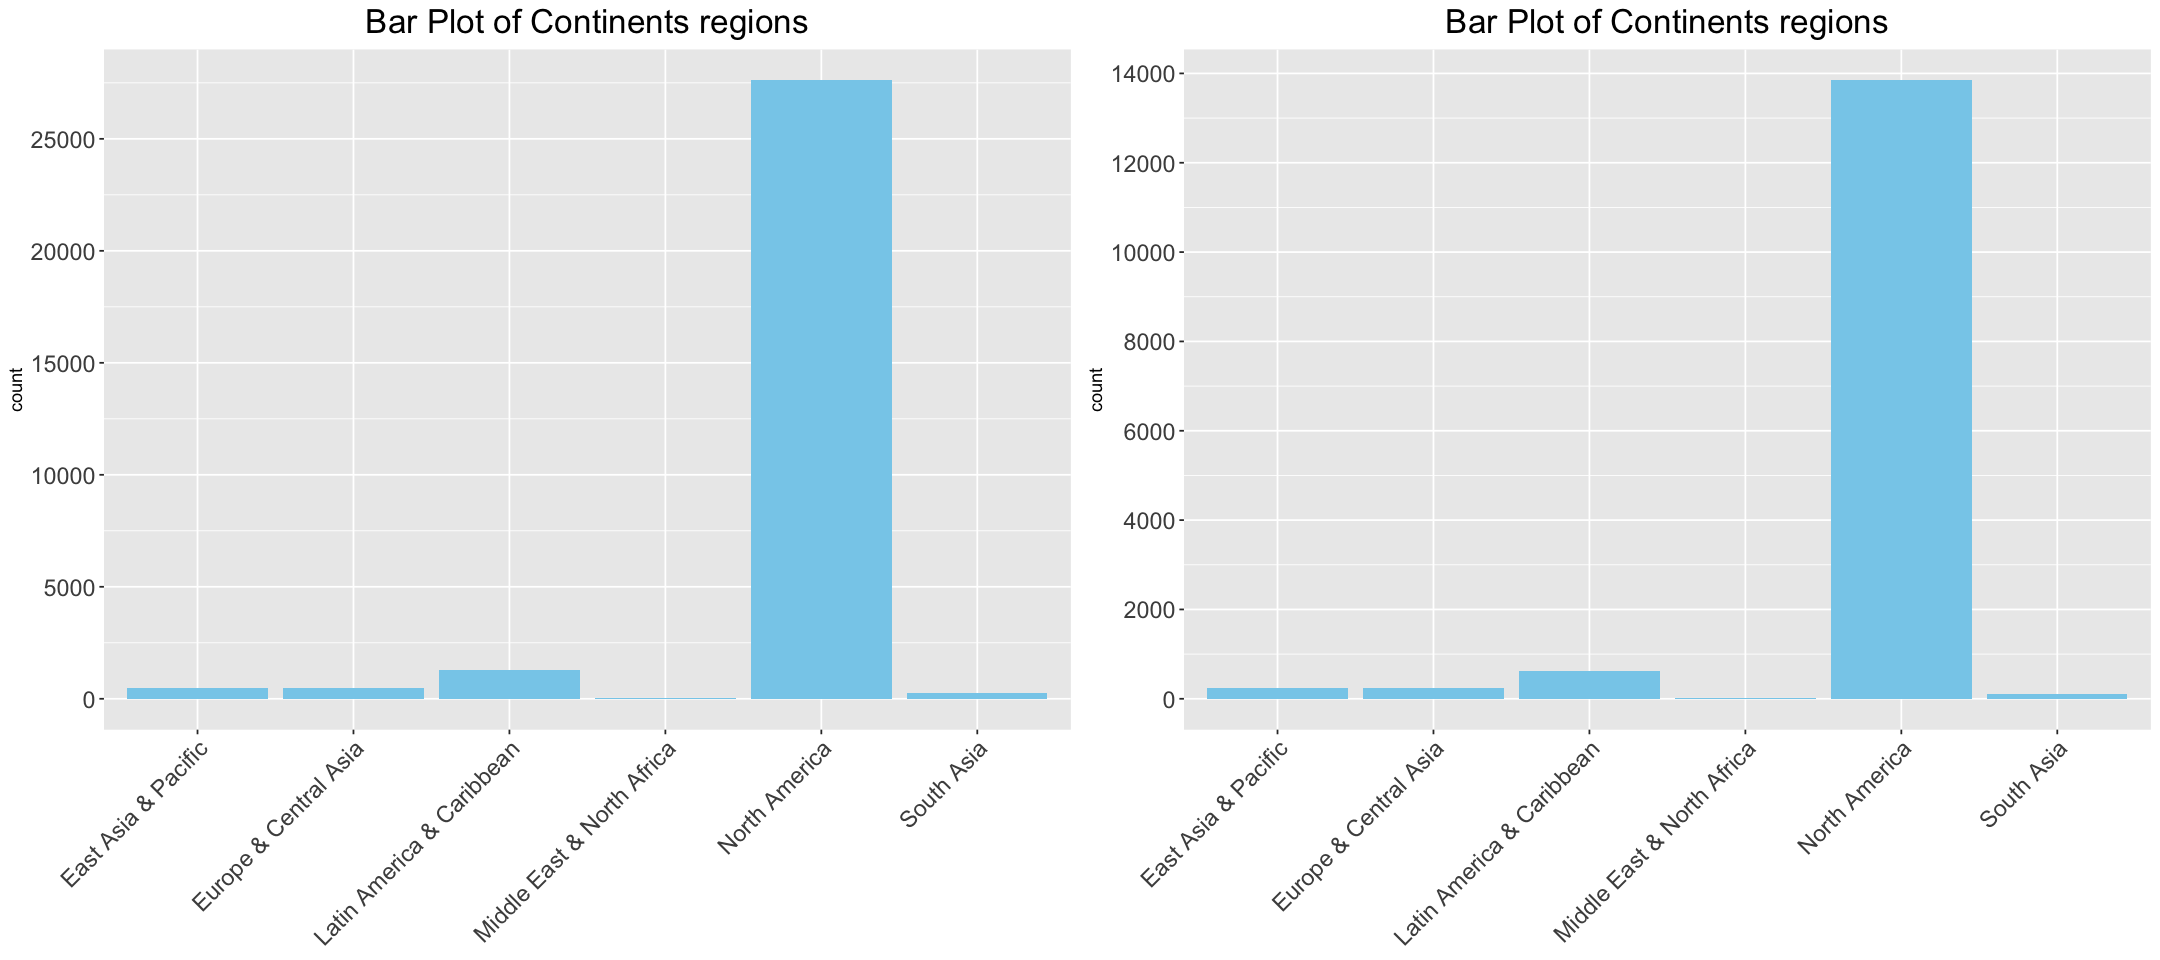

In [349]:
options(repr.plot.width=18, repr.plot.height=8)
continents_barplots <- plot_grid(continent_barplot_train, continent_barplot_test, ncol = 2, align = "h")
continents_barplots
# ggsave("images/income_densitiese.jpg" ,income_densities, width = 18, height = 8, units = "in", dpi = 300)

In [350]:
continent_barplot_train_no_america <- ggplot(subset(adult_data, continent != "North America"), aes(x = continent)) +
  geom_bar(fill='skyblue') +
  labs(title = "Bar Plot of Continents regions") +
  scale_y_continuous(breaks = pretty_breaks(n = 7)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size=14),
        axis.text.y = element_text(size=14),
        axis.title.x = element_blank(),
        plot.title = element_text(hjust = 0.5, size=20))

continent_barplot_test_no_america <- ggplot(subset(adult_test, continent != "North America"), aes(x = continent)) +
  geom_bar(fill='skyblue') +
  labs(title = "Bar Plot of Continents regions") +
  scale_y_continuous(breaks = pretty_breaks(n = 7)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size=14),
        axis.text.y = element_text(size=14),
        axis.title.x = element_blank(),
        plot.title = element_text(hjust = 0.5, size=20))

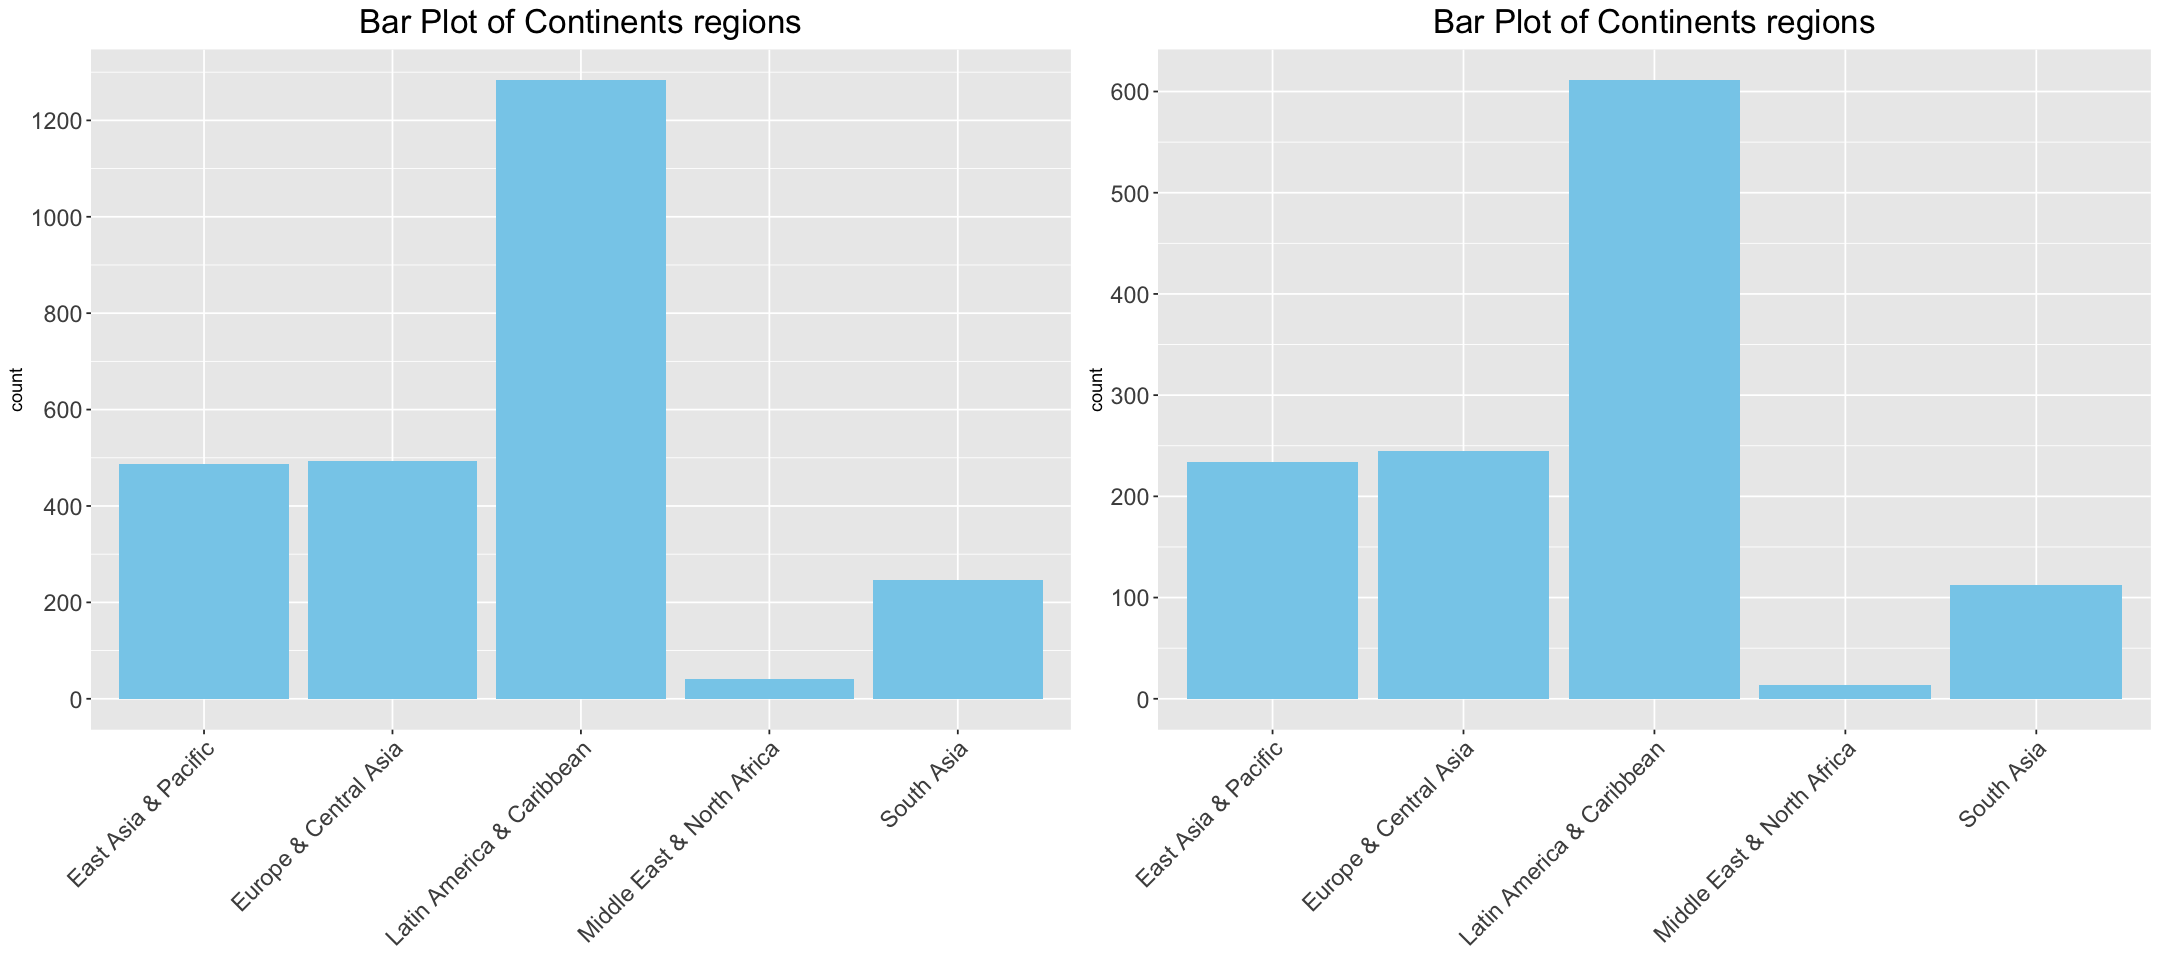

In [351]:
options(repr.plot.width=18, repr.plot.height=8)
continents_barplots_no_america <- plot_grid(continent_barplot_train_no_america, continent_barplot_test_no_america, ncol = 2, align = "h")
continents_barplots_no_america
# ggsave("images/income_densitiese.jpg" ,income_densities, width = 18, height = 8, units = "in", dpi = 300)

In [335]:
adult_data <- subset(adult_data, select = -c(native.country))
adult_test <- subset(adult_test, select = -c(native.country))

## Preparations for predictions

In [336]:
true.labels <- adult_test$income_binary

In [337]:
(n <- dim(adult_data)[1])
(n.test <- dim(adult_test)[1])

[1] 30161

[1] 15060

## Logistic regression

### All features

In [352]:
model.glm.all <- glm(income_binary ~ ., data=adult_data, family = "binomial")

In [353]:
pred.glm.all <- predict(model.glm.all, adult_test, type = "response")

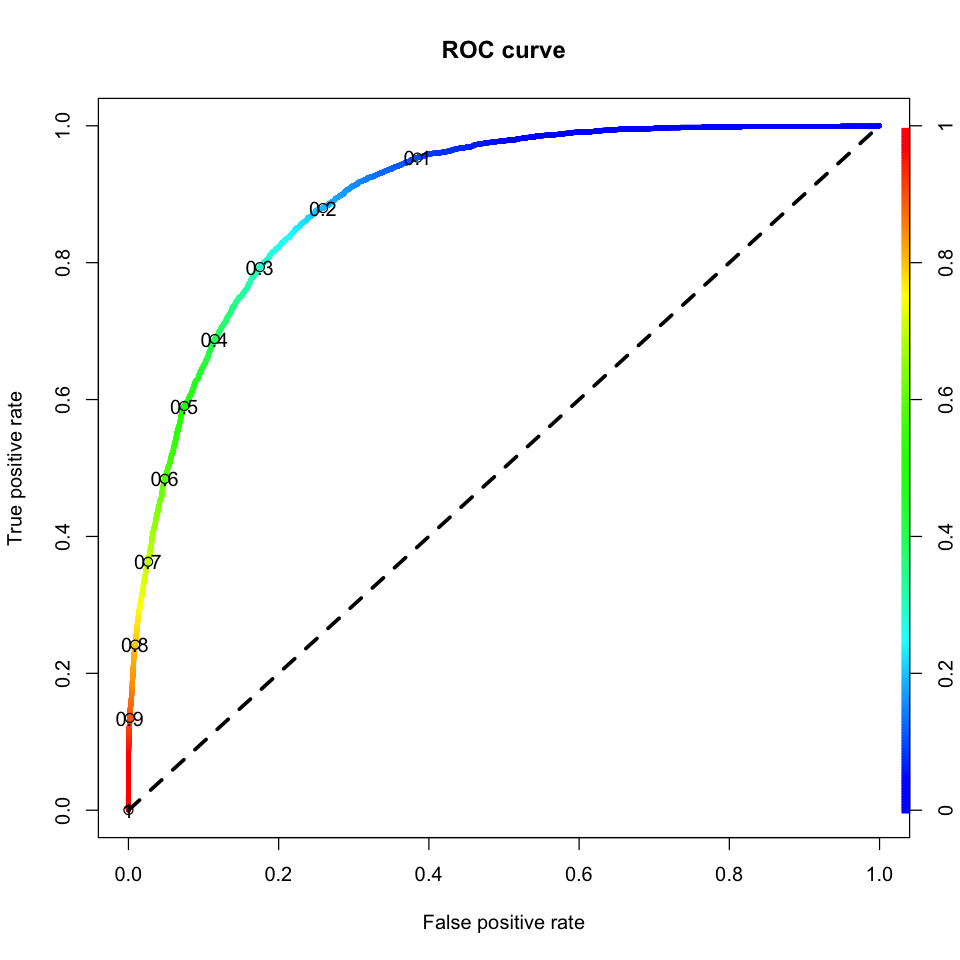

In [354]:
pred.ROCR.logit <- prediction(pred.glm.all, true.labels)
perf.ROCR.logit <- performance(pred.ROCR.logit, "tpr", "fpr")
options(repr.plot.width=8, repr.plot.height=8)

plot(perf.ROCR.logit, print.cutoffs.at=seq(0.1, 1, 0.1), colorize=TRUE, lwd=4)
lines(c(0,1), c(0,1), lwd=3, lty=2)
title("ROC curve")

In [355]:
glm.roc <- roc(true.labels, pred.glm.all)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [356]:
(glm.threshold <- coords(glm.roc, "best", best.method = "youden")[[1]])

[1] 0.2198111

In [357]:
predictions.glm <- ifelse(pred.glm.all >= glm.threshold, 1, 0)

In [441]:
confusion.matrix.glm.all <- table(true.labels, predictions.glm)
(caret.glm <- caret::confusionMatrix(confusion.matrix.glm.all))

Confusion Matrix and Statistics

           predictions.glm
true.labels    0    1
          0 8648 2712
          1  497 3203
                                          
               Accuracy : 0.7869          
                 95% CI : (0.7803, 0.7934)
    No Information Rate : 0.6072          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5217          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9457          
            Specificity : 0.5415          
         Pos Pred Value : 0.7613          
         Neg Pred Value : 0.8657          
             Prevalence : 0.6072          
         Detection Rate : 0.5742          
   Detection Prevalence : 0.7543          
      Balanced Accuracy : 0.7436          
                                          
       'Positive' Class : 0               
              

In [359]:
(misclass.error.glm <- (n.test - sum(diag(confusion.matrix.glm.all))) / n.test)

[1] 0.213081

In [360]:
(df.matrix.glm <- data.frame(confusion.matrix.glm.all))

true.labels,predictions.glm,Freq
<fct>,<fct>,<int>
0,0,8648
1,0,497
0,1,2712
1,1,3203


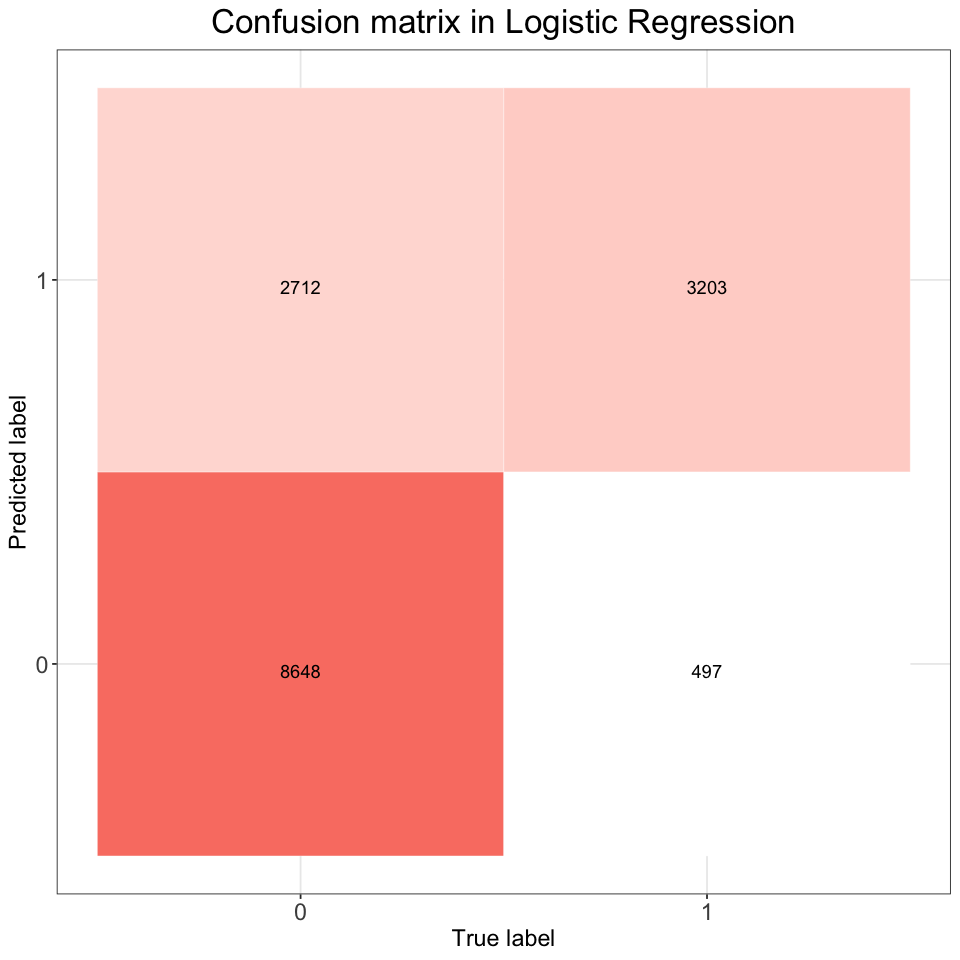

In [361]:
ggplot(data =  df.matrix.glm, mapping = aes(x = true.labels, y = predictions.glm)) +
  geom_tile(aes(fill = Freq), colour = "white") +
  geom_text(aes(label = sprintf("%1.0f", Freq)), vjust = 1) +
  scale_fill_gradient(low = "white", high = "salmon") +
  labs(title = "Confusion matrix in Logistic Regression", x = "True label", y = "Predicted label", fill = "Income") +

  theme_bw() + theme(legend.position = "none") +
  theme(axis.text.x = element_text(size = 14),
                              axis.text.y = element_text(size = 14),
                              axis.title.x = element_text(size = 14),
                              axis.title.y = element_text(size = 14),
                              plot.title = element_text(hjust = 0.5, size = 20),
                              legend.text = element_text(size = 14),
                              legend.position="none")

## k-NN

### All features

In [419]:
model.knn.all <- ipredknn(income_binary ~ . , data=adult_data, k=5)

In [420]:
predicted.labels.knn.all <- predict(model.knn.all, adult_test, type="class")

In [421]:
confusion.matrix.knn.all <- table(predicted.labels.knn.all, adult_test$income_binary)
(knn.all <- caret::confusionMatrix(confusion.matrix.knn.all))

Confusion Matrix and Statistics

                        
predicted.labels.knn.all     0     1
                       0 10357  1384
                       1  1003  2316
                                          
               Accuracy : 0.8415          
                 95% CI : (0.8356, 0.8473)
    No Information Rate : 0.7543          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.557           
                                          
 Mcnemar's Test P-Value : 7.379e-15       
                                          
            Sensitivity : 0.9117          
            Specificity : 0.6259          
         Pos Pred Value : 0.8821          
         Neg Pred Value : 0.6978          
             Prevalence : 0.7543          
         Detection Rate : 0.6877          
   Detection Prevalence : 0.7796          
      Balanced Accuracy : 0.7688          
                                          
       'Positi

In [422]:
(misclass.error.knn <- (n.test - sum(diag(confusion.matrix.knn.all))) / n.test)

[1] 0.1584993

In [423]:
(df.matrix.knn <- data.frame(confusion.matrix.knn.all))

predicted.labels.knn.all,Var2,Freq
<fct>,<fct>,<int>
0,0,10357
1,0,1003
0,1,1384
1,1,2316


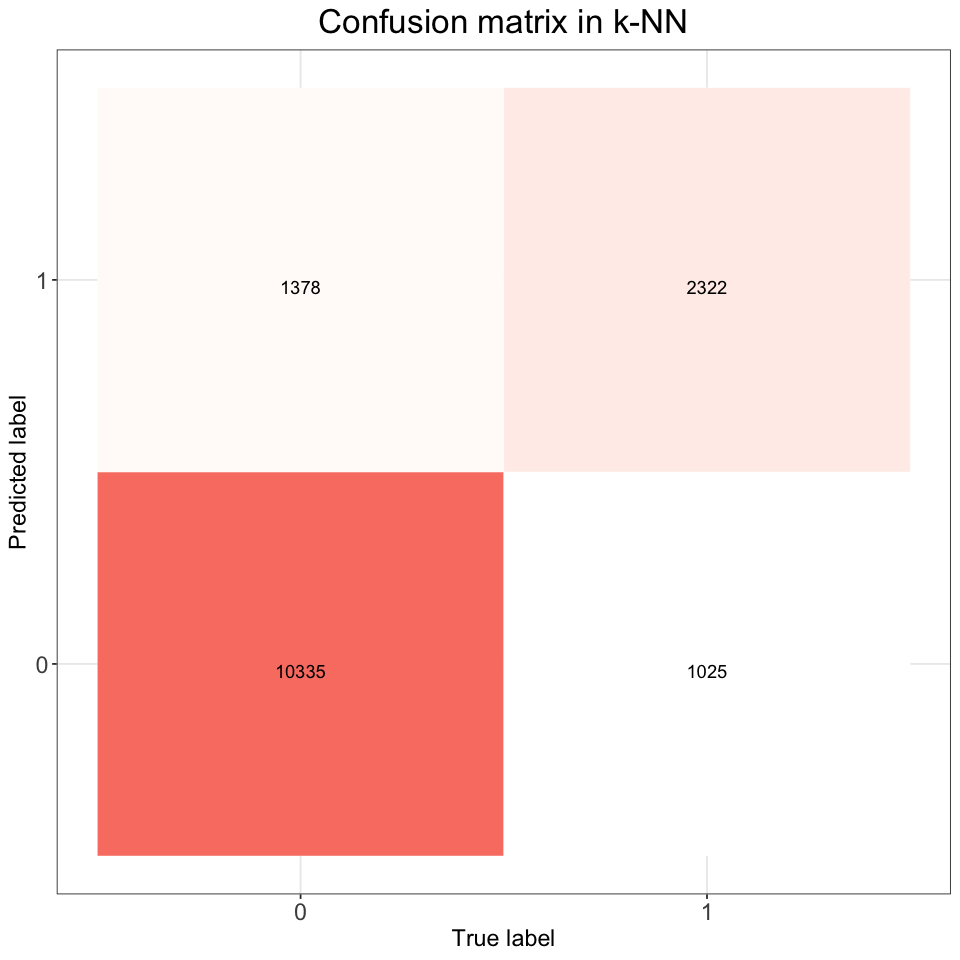

In [367]:
ggplot(data =  df.matrix.knn, mapping = aes(x = predicted.labels.knn.all, y = Var2)) +
  geom_tile(aes(fill = Freq), colour = "white") +
  geom_text(aes(label = sprintf("%1.0f", Freq)), vjust = 1) +
  scale_fill_gradient(low = "white", high = "salmon") +
  labs(title = "Confusion matrix in k-NN", x = "True label", y = "Predicted label", fill = "Income") +

  theme_bw() + theme(legend.position = "none") +
  theme(axis.text.x = element_text(size = 14),
                              axis.text.y = element_text(size = 14),
                              axis.title.x = element_text(size = 14),
                              axis.title.y = element_text(size = 14),
                              plot.title = element_text(hjust = 0.5, size = 20),
                              legend.text = element_text(size = 14),
                              legend.position="none")

## Random Forest

### All

In [368]:
rf.all <- randomForest(income_binary~., data=adult_data,
                        ntree=300, maxnodes=20)

In [369]:
rf.all


Call:
 randomForest(formula = income_binary ~ ., data = adult_data,      ntree = 300, maxnodes = 20) 
               Type of random forest: regression
                     Number of trees: 300
No. of variables tried at each split: 3

          Mean of squared residuals: 0.1084997
                    % Var explained: 41.97

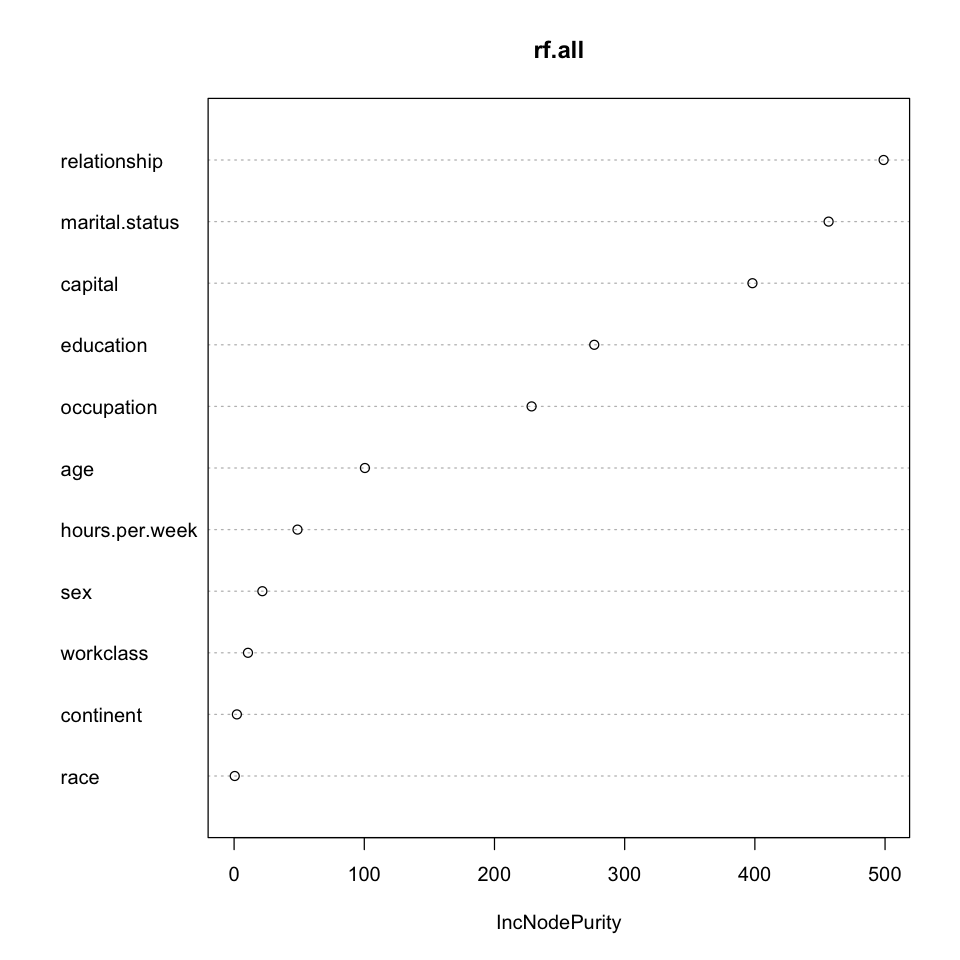

In [370]:
varImpPlot(rf.all)

In [376]:
predict.rf.all <- predict(rf.all,adult_test, type="class")

In [381]:
confusion.matrix.rf <- table(predict.rf.all, true.labels)
# (rf.matrix <- caret::confusionMatrix(confusion.matrix.rf))

ERROR: Error in !all.equal(nrow(data), ncol(data)): niepoprawny typ argumentu


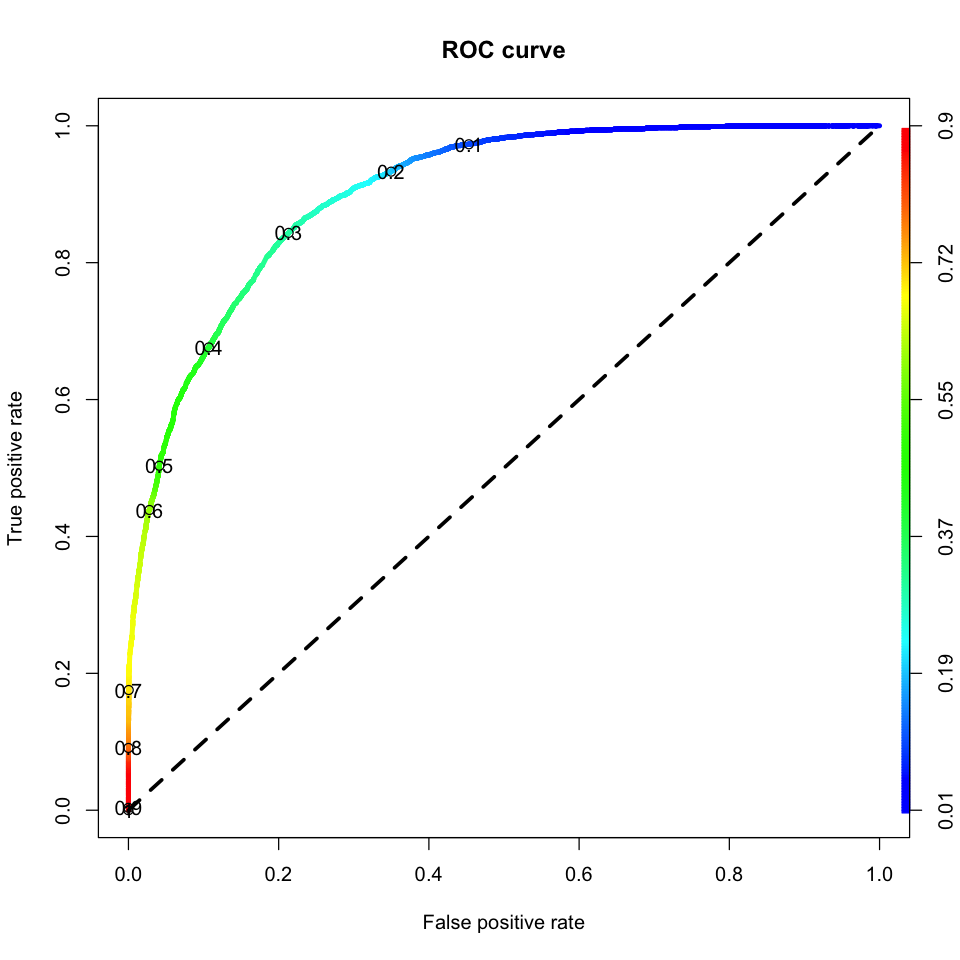

In [382]:
pred.ROCR.logit <- prediction(predict.rf.all, true.labels)
perf.ROCR.logit <- performance(pred.ROCR.logit, "tpr", "fpr")
options(repr.plot.width=8, repr.plot.height=8)

plot(perf.ROCR.logit, print.cutoffs.at=seq(0.1, 1, 0.1), colorize=TRUE, lwd=4)
lines(c(0,1), c(0,1), lwd=3, lty=2)
title("ROC curve")

In [384]:
rf.roc <- roc(true.labels, predict.rf.all)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [385]:
(rf.threshold <- coords(rf.roc, "best", best.method = "youden")[[1]])

[1] 0.2969602

In [388]:
predictions.rf <- ifelse(predict.rf.all >= rf.threshold, 1, 0)

In [440]:
confusion.matrix.rf.all <- table(true.labels, predictions.rf)
(caret.rf <- caret::confusionMatrix(confusion.matrix.rf.all))

Confusion Matrix and Statistics

           predictions.rf
true.labels    0    1
          0 8826 2534
          1  535 3165
                                          
               Accuracy : 0.7962          
                 95% CI : (0.7897, 0.8026)
    No Information Rate : 0.6216          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5349          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9428          
            Specificity : 0.5554          
         Pos Pred Value : 0.7769          
         Neg Pred Value : 0.8554          
             Prevalence : 0.6216          
         Detection Rate : 0.5861          
   Detection Prevalence : 0.7543          
      Balanced Accuracy : 0.7491          
                                          
       'Positive' Class : 0               
               

In [392]:
(misclass.error.rf <- (n.test - sum(diag(confusion.matrix.rf.all))) / n.test)

[1] 0.2037849

In [398]:
(df.matrix.rf <- data.frame(confusion.matrix.rf.all))

true.labels,predictions.rf,Freq
<fct>,<fct>,<int>
0,0,8826
1,0,535
0,1,2534
1,1,3165


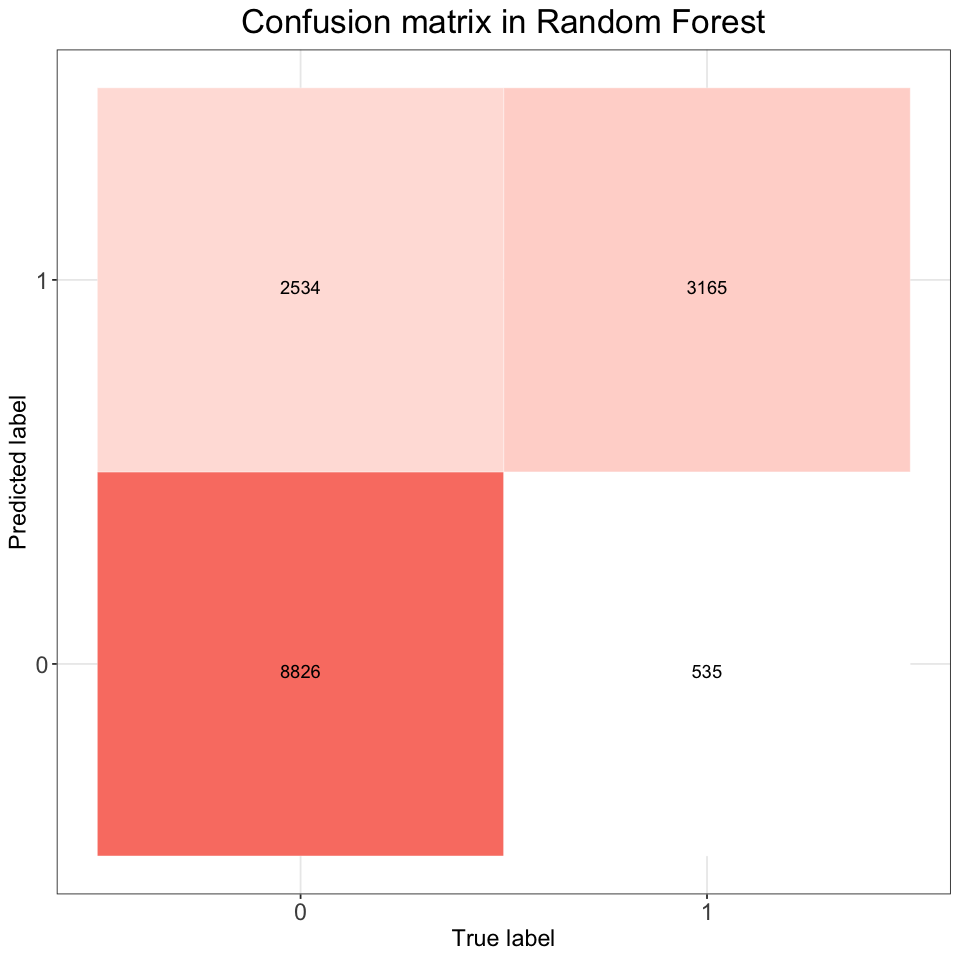

In [400]:
ggplot(data =  df.matrix.rf, mapping = aes(x = true.labels, y = predictions.rf)) +
  geom_tile(aes(fill = Freq), colour = "white") +
  geom_text(aes(label = sprintf("%1.0f", Freq)), vjust = 1) +
  scale_fill_gradient(low = "white", high = "salmon") +
  labs(title = "Confusion matrix in Random Forest", x = "True label", y = "Predicted label") +

  theme_bw() + theme(legend.position = "none") +
  theme(axis.text.x = element_text(size = 14),
                              axis.text.y = element_text(size = 14),
                              axis.title.x = element_text(size = 14),
                              axis.title.y = element_text(size = 14),
                              plot.title = element_text(hjust = 0.5, size = 20),
                              legend.text = element_text(size = 14),
                              legend.position="none")

# LDA

In [403]:
lda.all <- lda(income_binary~., data=adult_data)

In [407]:
predict.lda.all <- predict(lda.all,adult_test)

In [438]:
(pred.prob.lda <- predict.lda.all$posterior)
pred.labels.lda <- predict.lda.all$class

,0,1
1,0.98683450,0.013165503
2,0.86410740,0.135892600
3,0.62285755,0.377142447
4,0.66994674,0.330053264
5,0.98879005,0.011209946
6,0.09827468,0.901725321
7,0.98545729,0.014542707
8,0.93344308,0.066556924
9,0.63814485,0.361855147
10,0.31407374,0.685926259


In [437]:
confusion.matrix.lda <- table(pred.labels.lda, true.labels)
(caret.lda <- caret::confusionMatrix(confusion.matrix.lda))

Confusion Matrix and Statistics

               true.labels
pred.labels.lda     0     1
              0 10499  1632
              1   861  2068
                                          
               Accuracy : 0.8345          
                 95% CI : (0.8284, 0.8404)
    No Information Rate : 0.7543          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5196          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9242          
            Specificity : 0.5589          
         Pos Pred Value : 0.8655          
         Neg Pred Value : 0.7060          
             Prevalence : 0.7543          
         Detection Rate : 0.6971          
   Detection Prevalence : 0.8055          
      Balanced Accuracy : 0.7416          
                                          
       'Positive' Class : 0            

In [416]:
(misclass.error.lda <- (n.test-sum(diag(confusion.matrix.lda)))/n.test)

[1] 0.1655378

# Comparison

In [449]:
(metrics.df <- data.frame('GLM'=c(misclass.error.glm, caret.glm$overall["Accuracy"], caret.glm$byClass["Balanced Accuracy"]
                                         , caret.glm$byClass["Sensitivity"], caret.glm$byClass["Specificity"]), 
                                  'k-NN'=c(misclass.error.knn, knn.all$overall["Accuracy"], knn.all$byClass["Balanced Accuracy"]
                                         , knn.all$byClass["Sensitivity"], knn.all$byClass["Specificity"]), 
                                  'RF'=c(misclass.error.rf, caret.rf$overall["Accuracy"], caret.rf$byClass["Balanced Accuracy"]
                                         , caret.rf$byClass["Sensitivity"], caret.rf$byClass["Specificity"]), 
                                  'LDA'=c(misclass.error.lda, caret.lda$overall["Accuracy"], caret.lda$byClass["Balanced Accuracy"]
                                         , caret.lda$byClass["Sensitivity"], caret.lda$byClass["Specificity"]),
                                  row.names = c("Misclass error", "Accuracy","Balanced Accuracy", "Sensitivity", "Specificity")))

,GLM,k.NN,RF,LDA
,<dbl>,<dbl>,<dbl>,<dbl>
Misclass error,0.2130810,0.1584993,0.2037849,0.1655378
Accuracy,0.7869190,0.8415007,0.7962151,0.8344622
Balanced Accuracy,0.7435790,0.7688268,0.7491043,0.7415633
Sensitivity,0.9456534,0.9117077,0.9428480,0.9242077
Specificity,0.5415046,0.6259459,0.5553606,0.5589189
